# 自然语言处理介绍及实践

# 1. 基本概念

<img src='./image/nlp.jpg' />

自然语言处理是计算机科学领域与人工智能领域中的一个重要方向。它研究能实现人与计算机之间用自然语言进行有效通信的各种理论和方法。自然语言处理是一门融语言学、计算机科学、数学于一体的科学。因此，这一领域的研究将涉及自然语言，即人们日常使用的语言，所以它与语言学的研究有着密切的联系，但又有重要的区别。自然语言处理并不是一般地研究自然语言，而在于研制能有效地实现自然语言通信的计算机系统，特别是其中的软件系统。因而它是计算机科学的一部分。

自然语言处理（NLP）是计算机科学，人工智能，语言学关注计算机和人类（自然）语言之间的相互作用的领域。

作为data analyst，我们日常中的工作，很大一部分就是将信息从交易所、上市公司、基金公司公布的金融文档中提取出来。

比如基金名称，具体的林林总总的金融数据等，如果掌握自然语言处理技巧，或许能够对日常工作如虎添翼。

# 2. 主要范畴

文本朗读（Text to speech）/语音合成（Speech synthesis）

语音识别（Speech recognition）

中文自动分词（Chinese word segmentation）

词性标注（Part-of-speech tagging）

句法分析（Parsing）

自然语言生成（Natural language generation）

文本分类（Text categorization）

信息检索（Information retrieval）

信息抽取（Information extraction）

文字校对（Text-proofing）

问答系统（Question answering）

机器翻译（Machine translation）

自动摘要（Automatic summarization）

文字蕴涵（Textual entailment）

<img src='./image/nlparc.jpg' />

# 3. 常用套路

## 3.1 收集数据

对于我们analyst来说，就是从我们文档库里面，把我们关心的filing收集起来，然后最好按照句子为单位作为样本进行堆叠。

In [1]:
import spacy
nlp = spacy.load('en_core_web_sm')

我们拿如下这一段话，进行分句：

This prospectus offers variable annuity contract allowing you to accumulate values and paying you benefits on a variable and/or fixed basis. This prospectus provides information regarding the material provisions of your variable annuity contract. We may restrict the availability of this contract to certain broker-dealers. National Security Life V.I. and Annuity Company ("National Security") issues the contract. This contract is only available in New York.

In [2]:
def splitparagraph2sentence(paragraph):
    doc = nlp(paragraph)
    return [sentence.text for sentence in doc.sents]

In [3]:
sentences = splitparagraph2sentence('This prospectus offers variable annuity contract allowing you to accumulate values and paying you benefits on a variable and/or fixed basis. This prospectus provides information regarding the material provisions of your variable annuity contract. We may restrict the availability of this contract to certain broker-dealers. National Security Life V.I. and Annuity Company ("National Security") issues the contract. This contract is only available in New York.')
for sentence in sentences:
    print(sentence)

This prospectus offers variable annuity contract allowing you to accumulate values and paying you benefits on a variable and/or fixed basis.
This prospectus provides information regarding the material provisions of your variable annuity contract.
We may restrict the availability of this contract to certain broker-dealers.
National Security Life V.I. and Annuity Company ("National Security") issues the contract.
This contract is only available in New York.


注意：National Security Life V.I.中的点，没有被无脑作为分句的依据，而是真正根据语义分句。

<b>如果能够做有监督的分类，就顺手打上标签</b>，因为做无监督的聚类操作，然后根据相似度判断文本类型，耗时耗力，而且效果不是很好。

## 3.2 清洗数据

我们遵循的第一原则是：“再好的模型也拯救不了shi一样的数据”。所以，先来清洗一下数据吧！

我们做以下处理：
准则：去除变量，只留常量，或者可常量化。

1. 删除所有不相关的字符，如任何非字母数字字符

2. 通过文本分隔分成单独的单词来标记你的文章

3. 删除不相关的字词，例如“@”推特或网址

4. 将所有字符转换为小写字母，以便将诸如“hello”，“Hello”和“HELLO”等单词看做相同单词

5. 考虑整合拼写错误或多种拼写的单词，用一个单词代表（例如“cool”/“kewl”/“cooool”）相结合

6. 考虑词形还原（把“am”，“are”，“is”等词语缩小为“be”这样的常见形式）

7. 将所有专有名词转换为propn这个语义标注词，即变量转换为常量！

8. 去除停用词，比如for a an of the and to about after in among as...

具体实现方式：

### 删除所有非字母的字符
如这句话：Also assume that, when the Owner is age 76, a step up occurs and the highest quarterly Contract Value is greater than the BDB; in that case, the GAWA percentage will be re determined based on the Owner's attained age of 76, resulting in a new GAWA percentage of 6%.

In [4]:
import re
text = '''Also assume that, when the Owner is age 76, a step up occurs and the highest quarterly Contract Value is greater than the BDB; in that case, the GAWA percentage will be re determined based on the Owner's attained age of 76, resulting in a new GAWA percentage of 6%.'''
text = re.sub(r'\W', ' ', text)
text = re.sub(r'\d', ' ', text)
text = re.sub(r'( ){2,}', ' ', text).strip()
print(text)

Also assume that when the Owner is age a step up occurs and the highest quarterly Contract Value is greater than the BDB in that case the GAWA percentage will be re determined based on the Owner s attained age of resulting in a new GAWA percentage of


### 词性还原

#### 什么是词性？

词性指以词的特点作为划分词类的根据，比如：
ADV: 副词；sample：very, well, exactly, tomorrow, up, down

VERB: 动词；sample: run, eat, ate, running, eats

ADJ: 形容词；sample: big, old, green

DET: 限定词；sample: a, an, this, this, no

NOUN: 名词；sample: girl, boy, cat, tree

ADP: 介词；sample: in, to, during

PROPN: 专属名词；sample: Mary, London, HBO, Google

CCONJ: 连词；sample: and, or, but

参照：http://universaldependencies.org/u/pos/all.html

下面的例子，演示如何通过Spacy获取一句话中各个单词的词性

In [5]:
def getwordtokenattributes(text):
    doc = nlp(text)
    result = []
    wordlist = []
    for token in doc:
#         if token.text not in wordlist:
        dictinfo = {}
        dictinfo['text'] = token.text
        dictinfo['lemma_'] = token.lemma_
        dictinfo['pos_'] = token.pos_
        dictinfo['tag_'] = token.tag_
        dictinfo['dep_'] = token.dep_
        dictinfo['shape_'] = token.shape_
        dictinfo['is_alpha'] = token.is_alpha
        dictinfo['is_stop'] = token.is_stop
        wordlist.append(token.text)
        result.append(dictinfo)
    return result

In [6]:
result = getwordtokenattributes(r"It's supposed to be removed.")

In [7]:
print(result)

[{'text': 'It', 'lemma_': '-PRON-', 'pos_': 'PRON', 'tag_': 'PRP', 'dep_': 'nsubjpass', 'shape_': 'Xx', 'is_alpha': True, 'is_stop': False}, {'text': "'s", 'lemma_': 'be', 'pos_': 'VERB', 'tag_': 'VBZ', 'dep_': 'auxpass', 'shape_': "'x", 'is_alpha': False, 'is_stop': False}, {'text': 'supposed', 'lemma_': 'suppose', 'pos_': 'VERB', 'tag_': 'VBN', 'dep_': 'ROOT', 'shape_': 'xxxx', 'is_alpha': True, 'is_stop': False}, {'text': 'to', 'lemma_': 'to', 'pos_': 'PART', 'tag_': 'TO', 'dep_': 'aux', 'shape_': 'xx', 'is_alpha': True, 'is_stop': True}, {'text': 'be', 'lemma_': 'be', 'pos_': 'VERB', 'tag_': 'VB', 'dep_': 'auxpass', 'shape_': 'xx', 'is_alpha': True, 'is_stop': True}, {'text': 'removed', 'lemma_': 'remove', 'pos_': 'VERB', 'tag_': 'VBN', 'dep_': 'xcomp', 'shape_': 'xxxx', 'is_alpha': True, 'is_stop': False}, {'text': '.', 'lemma_': '.', 'pos_': 'PUNCT', 'tag_': '.', 'dep_': 'punct', 'shape_': '.', 'is_alpha': False, 'is_stop': False}]


我们可以用Pandas的DataFrame，将结果变得容易阅读：

In [8]:
import pandas as pd
df = pd.DataFrame(result)
df

,dep_,is_alpha,is_stop,lemma_,pos_,shape_,tag_,text
0,nsubjpass,True,False,-PRON-,PRON,Xx,PRP,It
1,auxpass,False,False,be,VERB,'x,VBZ,'s
2,ROOT,True,False,suppose,VERB,xxxx,VBN,supposed
3,aux,True,True,to,PART,xx,TO,to
4,auxpass,True,True,be,VERB,xx,VB,be
5,xcomp,True,False,remove,VERB,xxxx,VBN,removed
6,punct,False,False,.,PUNCT,.,.,.


#### 通过词性还原获得语干

In [9]:
def lemmatization(sentence, allowed_postags=''):
    """https://spacy.io/api/annotation"""
    doc = nlp(sentence)
    # allowed_postags, such as 'NOUN,ADJ,VERB,ADV',
    # 但是大多数情况，不能加allow_postags，否则很多词，比如no,  or就没有了
    if len(allowed_postags) > 0:
        resultlist = [token.lemma_
                      for token
                      in doc
                      if token.pos_
                      in [postag.upper().strip() for postag in allowed_postags.split(',')]]
    else:
        resultlist =  [token.lemma_ for token in doc]
    return resultlist

In [10]:
text = r'The product is the best than others.'

In [11]:
print(' '.join(lemmatization(text)))

the product be the good than other .


#### 通过词性表达式获得短语

In [12]:
import textacy
def extractverbphrase(text, pattern=r'(<ADV>*<NOUN|PROPN>*<VERB><DET>?<ADV>*<VERB|ADJ>+<ADP>?<DET>?<NUM>*<ADJ>*<NOUN|PROPN>*<ADV>?)|(<VERB>?<NOUN|PROPN>*<ADV>?<VERB><ADP>?<ADJ|VERB>*<ADP>?<DET>?<VERB>?<NOUN|PROPN>*)|(<DET>?<ADJ>+<NOUN|PROPN>+)|(<ADV>*<ADJ><ADP><DET>?<VERB|ADJ>*<NOUN|PROPN>*)|(<DET><NOUN><CCONJ><NOUN>)|(<NOUN|PROPN>*<CCONJ>?<NOUN|PROPN>+<ADP><NOUN|PROPN>+)|(<ADP><DET><NOUN|PROPN>+)'):
    # ADV: 副词；sample：very, well, exactly, tomorrow, up, down
    # VERB: 动词；sample: run, eat, ate, running, eats
    # ADJ: 形容词；sample: big, old, green
    # DET: 限定词；sample: a, an, this, this, no
    # NOUN: 名词；sample: girl, boy, cat, tree
    # ADP: 介词；sample: in, to, during
    # PROPN: 专属名词；sample: Mary, London, HBO, Google
    # CCONJ: 连词；sample: and, or, but
    # 参照：http://universaldependencies.org/u/pos/all.html
    doc = nlp(text)
    return list(textacy.extract.pos_regex_matches(doc, pattern))

In [13]:
text = r'Effective April 24, 2017, there are new Investment Divisions for which Accumulation Unit information is not yet available.'
phraselist = extractverbphrase(text, pattern=r'(<PROPN>+)')
for phrase in phraselist:
    print(phrase)

April
Investment Divisions
Accumulation Unit


#### 统一的文字清洗方法

将清理逻辑连接起来，构成一个统一的文字清洗方法：

In [14]:
import re

In [15]:
def removespecialchar(sentence):
    result = re.sub('\W', ' ', sentence)
    return re.sub('( ){2,}', ' ', result)

In [16]:
def clearandlemmasentence(sentence,
                          stopword='for a an the and in among'):
    stoplist = set(stopword.split())
    sentence = removespecialchar(sentence).lower().strip()
    sentence = ' '.join([word.strip() for word
                         in sentence.lower().strip().split()
                         if len(word.strip()) > 0
                         and word not in stoplist]).strip()
    sentence = re.sub(r'(propn\s+){2,}', 'propn ', sentence)
    if len(sentence) == 0:
        sentence = 'only for test'
    lemmawordlist = lemmatization(sentence)
    return lemmawordlist

In [17]:
def replacevariabletextfromtextblock(textblock):
    """
    Variable Text:
    1. PROPN words, such as: Mainstay VP Funds Trust, replace them with propn
    2. Date part, such as January 1, 2018, replace them with date
    3. Number, such as 1, 2, replace with space
    :param textblock:
    :return:
    """
    # replace date string with "date"
    datepattern = r'((January|February|March|April|May|June|July|August|September|October|November|December)[\s]*[0-9]{1,2}[\s]*,[\s]*[0-9]{4})|([0-9]{1,2}/[0-9]{1,2}/[0-9]{4})'
    textblock = re.sub(datepattern, 'date', textblock)
    datepattern = r'\d{2}\/\d{2}\/(\d{4}|\d{2})'
    textblock = re.sub(datepattern, 'date', textblock)
    # 应对*CTIVP这种情况，无法识别PROPN
    textblock = textblock.replace('*', ' ')
    textblock = re.sub(r'( ){2,}', ' ', textblock).strip()
    # 因为Money Market Fund前缀与后缀词经常是具体的基金公司，
    # 所以去除具体基金公司名称的同时，
    # 避免其被作为专属名词替换
    textblock = textblock.replace(' of ', ' ')\
        .replace(' Inc.', ' ')\
        .replace('&', '')\
        .replace(' LLC ', ' ')\
        .replace(' BlackRock ', ' ')\
        .replace(' SP ', ' ')
    textblock = textblock.replace('-', ' ').\
        replace('–', ' ').\
        replace('Addition', 'addition')
    textblock = re.sub(r'\d', ' ', textblock)
    textblock = re.sub(r'( ){2,}', ' ', textblock).strip()
    phraselist = extractverbphrase(textblock, '<PROPN>+')
    phraselist.sort(key=lambda i: len(i), reverse=True)
    if len(phraselist) > 0:
        for phrase in phraselist:
            phrasetext = phrase.text
            # avoid remove important words which are related with category
            if 'money market fund' in phrasetext.lower():
                textblock = textblock.replace(phrasetext, 'money market fund')
            noexcludewordlist = ['date',
                                 ' merge ',
                                 ' merged ',
                                 ' merging ',
                                 ' merger ',
                                 'acquir',
                                 'survive',
                                 'surviving',
                                 'survived',
                                 'liquidat',
                                 'transfer',
                                 'reorganiz',
                                 'expense table',
                                 'fee summary',
                                 'operating expenses',
                                 'annual fund',
                                 'the adviser',
                                 'benefit payment',
                                 'variable account option',
                                 ' new ']
            shouldignore = False
            for word in noexcludewordlist:
                if word in phrasetext.lower():
                    shouldignore = True
                    break
            if shouldignore:
                continue
            if not any([phrasetext.lower() == 'fund',
                        len(phrasetext.split()) <= 2]):
                textblock = textblock.replace(phrasetext, 'propn')
    textblock = textblock.replace('PIMCO', ' ')
    textblock = re.sub(r'\W', ' ', textblock)
    textblock = re.sub(r'(propn\s+){2,}', 'propn ', textblock)
    textblock = re.sub(r'( ){2,}', ' ', textblock).strip()
    return textblock

In [18]:
def cleardatafordoc2vector(doc):
    temp = ' '.join(
        clearandlemmasentence(replacevariabletextfromtextblock(doc),
                              'for a an of the and or to about after in among as at be been was were is are being b c d e f g h i j k l m n o p q r s t u v w x y z'
                              )).strip()
    temp = temp.replace('-PRON-', 'pron')
    return temp

现在可以做一下效果测试：<br>
原句：122 66 32 15 14 5 13 17 *CTIVP SM – Eaton Vance Floating Rate Income Fund (Class 2) liquidated on April 27, 2018. 

In [19]:
text = r'122 66 32 15 14 5 13 17 *CTIVP SM – Eaton Vance Floating Rate Income Fund (Class 2) liquidated on April 27, 2018. '
print(cleardatafordoc2vector(text))

propn class liquidate on date


## 3.3 找到一个好的数据表示方式

### 3.3.1 词袋化

Bag-of-words模型是信息检索领域常用的文档表示方法。

在信息检索中，BOW模型假定对于一个文档，忽略它的单词顺序和语法、句法等要素，将其仅仅看作是若干个词汇的集合，文档中每个单词的出现都是独立的，不依赖于其它单词是否出现。

也就是说，文档中任意一个位置出现的任何单词，都不受该文档语意影响而独立选择的。

词袋模型的缺点：

词袋模型最重要的是构造词表，然后通过文本为词表中的词赋值，但词袋模型严重缺乏相似词之间的表达。 

比如“我喜欢北京”“我不喜欢北京”其实这两个文本是严重不相似的。但词袋模型会判为高度相似。 

“我喜欢北京”与“我爱北京”其实表达的意思是非常非常的接近的，但词袋模型不能表示“喜欢”和“爱”之间严重的相似关系。（当然词袋模型也能给这两句话很高的相似度，但是注意我想表达的含义）

在Investment名字相似度这个应用中，正是采用了词袋 + TF/IDF模型 + 余弦相似度作为核心。因为单纯的investment并不存在或者很少存在需要语义分析。

下面是代码示例：

In [20]:
from gensim import corpora, models, similarities

d:\python36\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [21]:
namelist = [
    'ODDO BHF US Mid Cap CI-EUR H',
    'ODDO BHF US Mid Cap CR-USD',
    'Credit Suisse Index Fund (CH) - CSIF (CH) Bond Fiscal Strength EUR Blue ZA',
    'Winton Diversified Futures Fund (Luxembourg) C GBP Acc',
    'Prescient Core Equity Fund B5',
    'Robeco QI GTAA Plus DHL $',
    'Franklin US Rising Dividends T',
    'FT MLP Closed-End Fund & Energy 52 CA',
    'FT Richard Bern Adv TS Amer Ind 16-3 CA',
    'FT Municipal FT Income Select CE 81 CA',
    'Raiffeisen-Pensionsfonds-Österreich 2007 VT',
    'Multipartner SICAV - Carthesio Asian Credit Fund B EUR',
    'HSBC Wealth Strategic Solutions Fund (1) - Conservative Portfolio Income X',
    'American Beacon Flexible Bond Fund A Class',
    'Robeco QI GTAA Plus IHL $',
    'AXA World Funds - Global Equity Income M Capitalisation EUR']
stoplist = set('for a an of the and to in - $ &'.split())

In [22]:
data_train = []
for name in namelist:
    data_train.append([word for word in name.strip().split() 
                       if word not in stoplist])
print(data_train)

[['ODDO', 'BHF', 'US', 'Mid', 'Cap', 'CI-EUR', 'H'], ['ODDO', 'BHF', 'US', 'Mid', 'Cap', 'CR-USD'], ['Credit', 'Suisse', 'Index', 'Fund', '(CH)', 'CSIF', '(CH)', 'Bond', 'Fiscal', 'Strength', 'EUR', 'Blue', 'ZA'], ['Winton', 'Diversified', 'Futures', 'Fund', '(Luxembourg)', 'C', 'GBP', 'Acc'], ['Prescient', 'Core', 'Equity', 'Fund', 'B5'], ['Robeco', 'QI', 'GTAA', 'Plus', 'DHL'], ['Franklin', 'US', 'Rising', 'Dividends', 'T'], ['FT', 'MLP', 'Closed-End', 'Fund', 'Energy', '52', 'CA'], ['FT', 'Richard', 'Bern', 'Adv', 'TS', 'Amer', 'Ind', '16-3', 'CA'], ['FT', 'Municipal', 'FT', 'Income', 'Select', 'CE', '81', 'CA'], ['Raiffeisen-Pensionsfonds-Österreich', '2007', 'VT'], ['Multipartner', 'SICAV', 'Carthesio', 'Asian', 'Credit', 'Fund', 'B', 'EUR'], ['HSBC', 'Wealth', 'Strategic', 'Solutions', 'Fund', '(1)', 'Conservative', 'Portfolio', 'Income', 'X'], ['American', 'Beacon', 'Flexible', 'Bond', 'Fund', 'A', 'Class'], ['Robeco', 'QI', 'GTAA', 'Plus', 'IHL'], ['AXA', 'World', 'Funds', 'Glo

下面的代码演示如何生成词袋字典以及词袋模型，并保存为具体的文件

In [23]:
dictionary = corpora.Dictionary(data_train)
print('输出每个单词对应的索引编号')
print(dictionary.token2id)
dictpath = './nlpmodel/corpus.dict'
dictionary.save(dictpath)
corpus = [dictionary.doc2bow(text) for text in data_train]
print('输出当前句子中各个单词的索引编号以及出现频率')
for corpu in corpus:
    print(corpu)
modelpath = './nlpmodel/corpus.mm'
corpora.MmCorpus.serialize(modelpath, corpus)

输出每个单词对应的索引编号
{'BHF': 0, 'CI-EUR': 1, 'Cap': 2, 'H': 3, 'Mid': 4, 'ODDO': 5, 'US': 6, 'CR-USD': 7, '(CH)': 8, 'Blue': 9, 'Bond': 10, 'CSIF': 11, 'Credit': 12, 'EUR': 13, 'Fiscal': 14, 'Fund': 15, 'Index': 16, 'Strength': 17, 'Suisse': 18, 'ZA': 19, '(Luxembourg)': 20, 'Acc': 21, 'C': 22, 'Diversified': 23, 'Futures': 24, 'GBP': 25, 'Winton': 26, 'B5': 27, 'Core': 28, 'Equity': 29, 'Prescient': 30, 'DHL': 31, 'GTAA': 32, 'Plus': 33, 'QI': 34, 'Robeco': 35, 'Dividends': 36, 'Franklin': 37, 'Rising': 38, 'T': 39, '52': 40, 'CA': 41, 'Closed-End': 42, 'Energy': 43, 'FT': 44, 'MLP': 45, '16-3': 46, 'Adv': 47, 'Amer': 48, 'Bern': 49, 'Ind': 50, 'Richard': 51, 'TS': 52, '81': 53, 'CE': 54, 'Income': 55, 'Municipal': 56, 'Select': 57, '2007': 58, 'Raiffeisen-Pensionsfonds-Österreich': 59, 'VT': 60, 'Asian': 61, 'B': 62, 'Carthesio': 63, 'Multipartner': 64, 'SICAV': 65, '(1)': 66, 'Conservative': 67, 'HSBC': 68, 'Portfolio': 69, 'Solutions': 70, 'Strategic': 71, 'Wealth': 72, 'X': 73, 'A': 74, 

下文将演示如何通过TF/IDF模型求语句相似度：

In [24]:
# 初始化模型
corpus = corpora.MmCorpus(modelpath)
dictionary = corpora.Dictionary.load(dictpath)
tfidf_model = models.TfidfModel(corpus)
index = similarities.SparseMatrixSimilarity(
    tfidf_model[corpus],
    num_features=len(dictionary.keys()))

In [25]:
print('准备测试语句')
testtext = 'CR-USD ODDO Mid Cap Cap BHF US'.split()
doc_text_vec = dictionary.doc2bow(testtext)
print(doc_text_vec)

准备测试语句
[(0, 1), (2, 2), (4, 1), (5, 1), (6, 1), (7, 1)]


In [26]:
print('直接通过TF/IDF模型获取相似度, 返回数值越大，相似度越高')
print(index.get_similarities(doc_text_vec))

直接通过TF/IDF模型获取相似度, 返回数值越大，相似度越高
[2.0267534  2.8160036  0.         0.         0.         0.
 0.28899837 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [27]:
test_simi = index[tfidf_model[doc_text_vec]]
test_simi = sorted(enumerate(test_simi), key=lambda item: -item[1])
outputlist = [test for test in test_simi if test[1] > 0.2]
print(outputlist)

[(1, 0.9541586), (0, 0.6422975)]


如果想看与哪一句最相似，直接使用索引，从语料包拿就可以

In [28]:
print('raw sentence: ', ' '.join(testtext))
for output in outputlist:
    print(namelist[output[0]],'---------similarity: ', output[1])

raw sentence:  CR-USD ODDO Mid Cap Cap BHF US
ODDO BHF US Mid Cap CR-USD ---------similarity:  0.9541586
ODDO BHF US Mid Cap CI-EUR H ---------similarity:  0.6422975


### 3.3.2 Doc2Vector中的TaggedDocument

Doc2Vector其实与Word2Vector类似，都有语义分析成分，但是索引单位是句子

Doc2Vector的训练集的组成单元是TaggedDocument对象, 如下是官方说明：

Represents a document along with a tag, input document format for class: `gensim.models.doc2vec.Doc2Vec`.

A single document, made up of `words` (a list of unicode string tokens) and `tags` (a list of tokens).

Tags may be one or more unicode string tokens, but typical practice (which will also be the most memory-efficient) is for the tags list to include a unique integer id as the only tag.

In [29]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

In [30]:
sentencelist = [
    'may prize winner teacher bomb',
    'production value use cgi digital ink paint make thing look really slick voice fine well problem thing script',
    'got heart right place also wilt awhile',
    'prof movie goodness thing good movie',
    'well go forever',
    'overproduced generally disappointing effort likely rouse rush hour crowd']
x_train = []
for index, sentence in enumerate(sentencelist):
    document = TaggedDocument(sentence.split(), tags=['{0}'.format(index)])
    print(document)
    x_train.append(document)
# model_dm = Doc2Vec(x_train, min_count=1, window=3, size=200, sample=1e-3, negative=5, workers=2)
# print(model_dm)

TaggedDocument(['may', 'prize', 'winner', 'teacher', 'bomb'], ['0'])
TaggedDocument(['production', 'value', 'use', 'cgi', 'digital', 'ink', 'paint', 'make', 'thing', 'look', 'really', 'slick', 'voice', 'fine', 'well', 'problem', 'thing', 'script'], ['1'])
TaggedDocument(['got', 'heart', 'right', 'place', 'also', 'wilt', 'awhile'], ['2'])
TaggedDocument(['prof', 'movie', 'goodness', 'thing', 'good', 'movie'], ['3'])
TaggedDocument(['well', 'go', 'forever'], ['4'])
TaggedDocument(['overproduced', 'generally', 'disappointing', 'effort', 'likely', 'rouse', 'rush', 'hour', 'crowd'], ['5'])


### 3.3.3 Keras中的Tokenizer与pad_sequences

#### text.Tokenizer类

这个类用来对文本中的词进行统计计数，生成文档词典，以支持基于词典位序生成文本的向量表示。 
init(num_words) 构造函数，传入词典的最大值

##### 成员函数

- fit_on_text(texts) 使用一系列文档来生成token词典，texts为list类，每个元素为一个文档。
- texts_to_sequences(texts) 将多个文档转换为word下标的向量形式,shape为`[len(texts)，len(text)]` -- (文档数，每条文档的长度)
- texts_to_matrix(texts) 将多个文档转换为矩阵表示,shape为`[len(texts),num_words]`

##### 成员变量

- document_count 处理的文档数量
- word_index 一个dict，保存所有word对应的编号id，从<b>1</b>开始
- word_counts 一个dict，保存每个word在所有文档中出现的次数
- word_docs 一个dict，保存每个word出现的文档的数量
- index_docs 一个dict，保存word的id出现的文档的数量

示例：

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

Using TensorFlow backend.


In [32]:
sentencelist = [
    'may prize winner teacher bomb',
    'production value use cgi digital ink paint make thing look really slick voice fine well problem thing script',
    'got heart right place also wilt awhile',
    'prof movie goodness thing good movie',
    'well go forever',
    'overproduced generally disappointing effort likely rouse rush hour crowd']

In [33]:
print('text_to_word_sequence的用法与字符串的split用法类似')
print(text_to_word_sequence(sentencelist[0]))

text_to_word_sequence的用法与字符串的split用法类似
['may', 'prize', 'winner', 'teacher', 'bomb']


In [34]:
max_fatures = 2000

In [35]:
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(sentencelist)
print('tokenizer.word_counts')
print(tokenizer.word_counts)
print()
print('tokenizer.word_index')
print(tokenizer.word_index)
print()
print('tokenizer.word_docs')
print(tokenizer.word_docs)

print()
print('tokenizer.index_docs')
print(tokenizer.index_docs) 

tokenizer.word_counts
OrderedDict([('may', 1), ('prize', 1), ('winner', 1), ('teacher', 1), ('bomb', 1), ('production', 1), ('value', 1), ('use', 1), ('cgi', 1), ('digital', 1), ('ink', 1), ('paint', 1), ('make', 1), ('thing', 3), ('look', 1), ('really', 1), ('slick', 1), ('voice', 1), ('fine', 1), ('well', 2), ('problem', 1), ('script', 1), ('got', 1), ('heart', 1), ('right', 1), ('place', 1), ('also', 1), ('wilt', 1), ('awhile', 1), ('prof', 1), ('movie', 2), ('goodness', 1), ('good', 1), ('go', 1), ('forever', 1), ('overproduced', 1), ('generally', 1), ('disappointing', 1), ('effort', 1), ('likely', 1), ('rouse', 1), ('rush', 1), ('hour', 1), ('crowd', 1)])

tokenizer.word_index
{'thing': 1, 'well': 2, 'movie': 3, 'may': 4, 'prize': 5, 'winner': 6, 'teacher': 7, 'bomb': 8, 'production': 9, 'value': 10, 'use': 11, 'cgi': 12, 'digital': 13, 'ink': 14, 'paint': 15, 'make': 16, 'look': 17, 'really': 18, 'slick': 19, 'voice': 20, 'fine': 21, 'problem': 22, 'script': 23, 'got': 24, 'heart

In [36]:
sequences = tokenizer.texts_to_sequences(sentencelist)
print(sequences)

[[4, 5, 6, 7, 8], [9, 10, 11, 12, 13, 14, 15, 16, 1, 17, 18, 19, 20, 21, 2, 22, 1, 23], [24, 25, 26, 27, 28, 29, 30], [31, 3, 32, 1, 33, 3], [2, 34, 35], [36, 37, 38, 39, 40, 41, 42, 43, 44]]


One_Hot化

In [37]:
print(tokenizer.texts_to_matrix(sentencelist))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


pad_sequences非常重要，目的是将序列填充到maxlen长度，不足maxlenth的句子，用0填充

<b><font color='red'>这个非常重要，Keras用于做分类训练的样本，需要通过填充对齐，才能进行之后的训练</font></b>

In [38]:
X = pad_sequences(sequences, maxlen=20)
print(X)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  5  6  7  8]
 [ 0  0  9 10 11 12 13 14 15 16  1 17 18 19 20 21  2 22  1 23]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 24 25 26 27 28 29 30]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 31  3 32  1 33  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2 34 35]
 [ 0  0  0  0  0  0  0  0  0  0  0 36 37 38 39 40 41 42 43 44]]


## 3.4 训练模型

文本清洗，词袋化或“向量化”（这里向量化打引号，表示与真正的词向量概率不同，这里仅仅是将词或句建立向量索引）之后，就是建模了。

上述部分已经提及了如何创建TF/IDF这种简单模型，那么如何创建词向量模型(word2vec)，句向量(doc2vec)以及通过Keras创建LSTM, biLSTM, GRU乃至biGRU模型呢？

我们将在`5. 常用模型`这一章详细了解。

## 3.5 使用模型

我们将在`5. 常用模型`这一章详细了解。

# 4. 常用自然语言处理包

工欲善其事，必先利其器。目前为止已经有很多很多用于NLP专项应用的python包。

下面将逐一介绍它们。

## 4.1 Gensim

<img src='./image/gensimoffice.png' />

Gensim是一个用于从文档中自动提取语义主题的Python库，足够智能。

Gensim可以处理原生，非结构化的数值化文本(纯文本)。Gensim里面的算法，比如Latent Semantic Analysis(潜在语义分析LSA)，Latent Dirichlet Allocation，Random Projections，通过在语料库的训练下检验词的统计共生模式(statistical co-occurrence patterns)来发现文档的语义结构。

这些算法是无监督的，也就是说你只需要一个语料库的文档集。

当得到这些统计模式后，任何文本都能够用语义表示(semantic representation)来简洁的表达，并得到一个局部的相似度与其他文本区分开来。

常用的功能有：语料(Corpus)，TF/IDF、LSA、LDA模型，Word2Vec, Doc2Vec, 以及通过各种模型获得单词、语句间的相似度。这些都是无监督使用方式。

但是，如果Doc2Vec的TaggedDocument使用得当，甚至可以起到有监督的语句分类的功效。

安装方式：`pip install -U gensim`

可以从Github获取源码：[Gensim on Github](https://github.com/RaRe-Technologies/gensim)

<img src='./image/gensimongithub.png' />

官方站点：[Gensim](https://radimrehurek.com/gensim/)

<img src='./image/gensimoffice2.png' />

第三方文档教程：[gensim](https://kite.com/python/docs/gensim)

<img src='./image/gensimonkite.png' />

很有特色的英文教程：[Gensim Tutorial – A Complete Beginners Guide](https://www.machinelearningplus.com/nlp/gensim-tutorial/)

<img src='./image/gensimtutorial.png' />

## 4.2 Spacy

Spacy是由`Cython`编写，因此它是一个非常快的库，可以说是工业级别的NLP组件库。

Spacy源自预训练统计模型，词向量，并且支持30+语言。

其号称具有最快的语法解析器，通过卷积神经网络CNN（convolutional neural network models）做token标注、解析以及命名实体识别，并且很方便做深度学习整合应用。

Spacy是商业开源软件，基于MIT license发布。

Spacy的特点与功能：

- Fastest syntactic parser in the world
- Named entity recognition
- Non-destructive tokenization
- Support for 30+ languages
- Pre-trained statistical models and word vectors
- Easy deep learning integration
- Part-of-speech tagging
- Labelled dependency parsing
- Syntax-driven sentence segmentation
- Built in visualizers for syntax and NER
- Convenient string-to-hash mapping
- Export to numpy data arrays
- Efficient binary serialization
- Easy model packaging and deployment
- State-of-the-art speed
- Robust, rigorously evaluated accuracy

安装方式：`pip install spacy`或者`pip install -U spacy`

在第三章中，我们使用Spacy做了分句，单词原型化，根据词性表达式获取短语等应用，而这一切都是是基于模型应用的，下面介绍如何下载语言模型。

最简单的下载模型方式，是基于Spacy的download命令：

```
# out-of-the-box: download best-matching default model
python -m spacy download en
python -m spacy download de
python -m spacy download es
python -m spacy download pt
python -m spacy download fr
python -m spacy download it
python -m spacy download nl
python -m spacy download xx

# download best-matching version of specific model for your spaCy installation
python -m spacy download en_core_web_sm

# download exact model version (doesn't create shortcut link)
python -m spacy download en_core_web_sm-2.0.0 --direct
```

模型下载相关的文档位于：[Models Overview](https://spacy.io/models/)

如果想获得特别全的英文词向量模型，可以下载：`python -m spacy download en_core_web_lg`

昨天举了很多Spacy有关的例子，这里再举一个命名实体识别的例子

In [39]:
import spacy
nlp = spacy.load('en')
doc = nlp("""Mary has a dog, she works for Google, 
and likes to buy things on Amazon, 
she is living in New York.""")
result = {}
for ent in doc.ents:
    if ent.label_ not in result.keys():
        result[ent.label_] = []
    if ent.text.strip() != "":
        result[ent.label_].append(ent.text.strip())
#remove duplicate entity values
for key in result.keys():
    l = []
    for label in result[key]:
        if not label in l:
            l.append(label)
    result[key] = l
print(result)

{'PERSON': ['Mary'], 'ORG': ['Google,', 'Amazon'], 'GPE': ['New York']}


命名实体识别可视化的方式：

通过如下代码，即可通过访问http://localhost:5000 的网址浏览实体识别的具体信息。

In [40]:
from spacy import displacy
displacy.serve(doc, style='ent')


    Serving on port 5000...
    Using the 'ent' visualizer


    Shutting down server on port 5000.



效果大致如下：

<img src='./image/spacyentity.png' />

Github地址：[spaCy: Industrial-strength NLP](https://github.com/explosion/spaCy)

<img src='./image/spacygithub.png' />

官方介绍及教程：[Spacy: Industrial-Strength
Natural Language
Processing](https://spacy.io/)

## 4.3 textacy

textacy是基于Spacy开发的自然语言任务工具，相关特性如下：

- Provide a convenient entry point and interface to one or many documents, with the core processing delegated to spaCy
- Stream text, json, csv, spaCy binary, and other data to and from disk
- Download and explore a variety of included datasets with both text content and metadata, from Congressional speeches to historical literature to Reddit comments
- Clean and normalize raw text, before analyzing it
- Access and filter basic linguistic elements, such as words, ngrams, and noun chunks; extract named entities, acronyms and their definitions, and key terms
- Flexibly tokenize and vectorize documents and corpora, then train, interpret, and visualize topic models using LSA, LDA, or NMF methods
- Compare strings, sets, and documents by a variety of similarity metrics
- Calculate common text statistics, including Flesch-Kincaid Grade Level, SMOG Index, and multilingual Flesch Reading Ease

安装方法：`pip install textacy`

之所以用textacy，是因为其可以预处理文本，比如:
去除URLs: 统一替换为url
Email：统一替换为email
Number: 统一替换为number
标点符号，
重音符号，
HTML标记等，如： 

In [41]:
import textacy
rawtext = """Please visit http://www.google.com, 
then you will get what you want to search. 
There are over 1000 web pages to review.
Please contact me by a@gmail.com."""
text = textacy.preprocess_text(rawtext, 
                               no_urls=True, 
                               no_numbers=True, 
                               no_emails=True,
                               lowercase=True, 
                               no_punct=True)
print(text)

please visit url then you will get what you want to search there are over number web pages to review please contact me by email


In [42]:
help(textacy.preprocess_text)

Help on function preprocess_text in module textacy.preprocess:

preprocess_text(text, fix_unicode=False, lowercase=False, transliterate=False, no_urls=False, no_emails=False, no_phone_numbers=False, no_numbers=False, no_currency_symbols=False, no_punct=False, no_contractions=False, no_accents=False)
    Normalize various aspects of a raw text doc before parsing it with Spacy.
    A convenience function for applying all other preprocessing functions in one go.
    
    Args:
        text (str): raw text to preprocess
        fix_unicode (bool): if True, fix "broken" unicode such as
            mojibake and garbled HTML entities
        lowercase (bool): if True, all text is lower-cased
        transliterate (bool): if True, convert non-ascii characters
            into their closest ascii equivalents
        no_urls (bool): if True, replace all URL strings with '*URL*'
        no_emails (bool): if True, replace all email strings with '*EMAIL*'
        no_phone_numbers (bool): if True, r

除此之外，textacy通过`textacy.Doc`的方式，能够<b>自动检测加载文本的语言</b>。

In [43]:
text = 'Tom is happily running in the park'
doc = textacy.Doc(text)

In [44]:
# help(textacy.Doc)

此外，还提供词性正则表达式的功能，可以方便获取想要的短语组合：

In [45]:
pattern = r'(<NOUN|PROPN>+<VERB>+<DET>?<ADV>*<VERB>+)'
phraselist = list(textacy.extract.pos_regex_matches(doc, pattern))
print([phrase.text for phrase in phraselist])

['Tom is happily running']


textacy的github地址：[textacy: NLP, before and after spaCy](https://github.com/chartbeat-labs/textacy)

<img src='./image/textacygithub.png' />

官方说明文档: [textacy: NLP, before and after spaCy](https://chartbeat-labs.github.io/textacy/index.html)

<img src='./image/textacytutorial.png' />

## 4.4 NLTK

NLTK是一个高效的Python构建的平台，用来处理人类自然语言数据。它提供了易于使用的接口，通过这些接口可以访问超过50个语料库和词汇资源（如WordNet），还有一套用于分类、标记化、词干标记、解析和语义推理的文本处理库，以及工业级NLP库的封装器和一个活跃的讨论论坛。

统计语言学话题方面的手动编程指南加上全面的API文档，使得NLTK非常适用于语言学家、工程师、学生、教育家、研究人员以及行业用户等人群。NLTK可以在Windows、Mac OS X以及Linux系统上使用。最好的一点是，NLTK是一个免费、开源的社区驱动的项目。

NLTK被称为“一个使用Python开发的用于统计语言学的教学和研究的有利工具”和“一个自然语言处理的高效库”。

相比Spacy之类的自然语言处理包，NLTK有一些偏学术化。

Github地址：[NLTK](https://github.com/nltk/nltk)

官方地址：[NLTK](https://www.nltk.org/)

## 4.5 JIEBA

Jieba（结巴）是一个强大的分词库，完美支持中文分词。

一般来说中文文本不会如同拉丁语系一样，词与词之间有明显的空格作为间隔。

如果需要对中文文本建模，那么分词是必须的前提条件，那么Jieba就是目前为止最好的中文分词组件包。

其优点有：

1 支持三种分词模式：

a. 精确模式，试图将句子最精确地切开，适合文本分析；

b. 全模式，把句子中所有的可以成词的词语都扫描出来, 速度非常快，但是不能解决歧义；

c. 搜索引擎模式，在精确模式的基础上，对长词再次切分，提高召回率，适合用于搜索引擎分词。

2 支持自定义词典

下面来看看如何对中文做分词：

### 精准模式

试图将句子最精确地切开,适合文本分析

In [46]:
import jieba
text = r'小张毕业于深圳大学，这座大学位于南山区'

In [47]:
words = jieba.cut(text)
print('/'.join(words))

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\bhe\AppData\Local\Temp\jieba.cache
Loading model cost 1.194 seconds.
Prefix dict has been built succesfully.


小张/毕业/于/深圳大学/，/这座/大学/位于/南山区


### 全模式

把句子中所有的可以成词的词语都扫描出来, 速度非常快,但是不能解决歧义

In [48]:
words = jieba.cut(text, cut_all=True)
print('/'.join(words))

小张/毕业/于/深圳/深圳大学/大学///这/座/大学/学位/位于/南山/南山区/山区


### 搜索引擎模式

在精确模式的基础上,对长词再次切分,提高召回率,适合用于搜索引擎分词

In [49]:
output = jieba.cut_for_search(text)
print('/'.join(output))

小张/毕业/于/深圳/大学/深圳大学/，/这座/大学/位于/南山/山区/南山区


### 词性标注

In [50]:
import jieba.posseg as pseg
words = pseg.cut(text)
for word, flag in words:
    print('单词：{0}, 词性：{1}'.format(word, flag))

单词：小张, 词性：n
单词：毕业, 词性：n
单词：于, 词性：p
单词：深圳大学, 词性：nt
单词：，, 词性：x
单词：这, 词性：r
单词：座, 词性：q
单词：大学, 词性：n
单词：位于, 词性：v
单词：南山区, 词性：ns


### 关键词提取

Jieba的关键词提取功能，是基于TF-IDF算法的

In [51]:
import jieba.analyse as analyse
text = """欧冠提前一轮出线，近四场比赛取得3胜1平，距离终结联赛对巴萨的不胜纪录也只有一步之遥，
马德里竞技似乎已经完全从惨败威斯特法伦一役的阴霾中走了出来。
球队近来的成绩有所提升，但困扰西蒙尼的战术难题并没有得到解决，
马德里竞技要取得一场的胜利似乎总是要付出比其他球队更多的努力，双线战场18战仅仅打入26球，
场均丢球数却达到了数年来的峰值，联赛中的两大竞争对手均状态不佳，欧冠分组也十分有利，
但马德里竞技依然没能如人们预期的那样脱颖而出，更为尴尬的是，
他们此次已经不能像上赛季那样以引援不力作为借口了。"""
print("  ".join(analyse.extract_tags(text, topK=20, withWeight=False, allowPOS=())))

竞技  马德里  欧冠  联赛  球队  一役  西蒙尼  18  26  场均  丢球数  引援  四场  威斯特法伦  上赛季  那样  取得  巴萨  似乎  出线


# 5. 常用模型

## 5.1 TF/ IDF

### 5.1.1 概念

TF-IDF（term frequency–inverse document frequency）是一种用于资讯检索与资讯探勘的常用加权技术。
   
TF-IDF是一种统计方法，用以评估一字词对于一个文件集或一个语料库中的其中一份文件的重要程度。
   
<b>字词的重要性随着它在文件中出现的次数成正比增加，但同时会随着它在语料库中出现的频率成反比下降。</b>
   
TF-IDF加权的各种形式常被搜寻引擎应用，作为文件与用户查询之间相关程度的度量或评级。
   
除了TF-IDF以外，因特网上的搜寻引擎还会使用基于连结分析的评级方法，以确定文件在搜寻结果中出现的顺序。

### 5.1.2 原理

在一份给定的文件里，<b>词频 (term frequency, TF)</b> 指的是某一个给定的词语在该文件中出现的次数。这个数字通常会被归一化（分子一般小于分母 区别于IDF），以防止它偏向长的文件。（同一个词语在长文件里可能会比短文件有更高的词频，而不管该词语重要与否。）

<b>逆向文件频率 (inverse document frequency, IDF)</b> 是一个词语普遍重要性的度量。某一特定词语的IDF，可以由总文件数目除以包含该词语之文件的数目，再将得到的商取对数得到。

某一特定文件内的高词语频率，以及该词语在整个文件集合中的低文件频率，可以产生出高权重的TF-IDF。因此，TF-IDF倾向于过滤掉常见的词语，保留重要的词语。

<b>TF-IDF的主要思想是：</b>

如果某个词或短语在一篇文章中出现的频率TF高，并且在其他文章中很少出现，则认为此词或者短语具有很好的类别区分能力，适合用来分类。

TF-IDF实际上是：TF * IDF，TF词频(Term Frequency)，IDF反文档频率(Inverse Document Frequency)。

TF表示词条在文档d中出现的频率（另一说：TF词频(Term Frequency)指的是某一个给定的词语在该文件中出现的次数）。

IDF的主要思想是：如果包含词条t的文档越少，也就是n越小，IDF越大，则说明词条t具有很好的类别区分能力。

如果某一类文档C中包含词条t的文档数为m，而其它类包含t的文档总数为k，显然所有包含t的文档数n=m+k，当m大的时候，n也大，按照IDF公式得到的IDF的值会小，就说明该词条t类别区分能力不强。

（另一说：IDF反文档频率(Inverse Document Frequency)是指果包含词条的文档越少，IDF越大，则说明词条具有很好的类别区分能力。）

但是实际上，如果一个词条在一个类的文档中频繁出现，则说明该词条能够很好代表这个类的文本的特征，这样的词条应该给它们赋予较高的权重，并选来作为该类文本的特征词以区别与其它类文档。这就是IDF的不足之处.

最简单的直观公式：

<img src='./image/tf1.png' />

<img src='./image/idf.png' />

<img src='./image/tfidf.png' />

学术一些的公式如下：

<img src='./image/tfidf_math.png' />

维基百科的地址:[tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

示例见本文的：3.3.1

### 5.1.3 与余弦相似度的结合应用

余弦相似度的维基百科定义：[Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)

比如两个句子：

句子A: 我喜欢看电视，不喜欢看电影。

句子B: 我不喜欢看电视，也不喜欢看电影。

1. 经过分词与计算词频：

句子A：我 1，喜欢 2，看 2，电视 1，电影 1，不 1，也 0。

句子B：我 1，喜欢 2，看 2，电视 1，电影 1，不 2，也 1。

2. 写出词频向量

句子A：[1, 2, 2, 1, 1, 1, 0]

句子B：[1, 2, 2, 1, 1, 2, 1]

到这里，问题就变成了如何计算这两个向量的相似程度。

我们可以把它们想象成空间中的两条线段，都是从原点（[0, 0, ...]）出发，指向不同的方向。

两条线段之间形成一个夹角，如果夹角为0度，意味着方向相同、线段重合；如果夹角为90度，意味着形成直角，方向完全不相似；如果夹角为180度，意味着方向正好相反。

因此，我们可以通过夹角的大小，来判断向量的相似程度。夹角越小，就代表越相似。

<img src='./image/cos1.png' />

以二维空间为例，上图的a和b是两个向量，我们要计算它们的夹角θ。余弦定理告诉我们，可以用下面的公式求得：

<img src='./image/cos2.png' />

<img src='./image/cos3.png' />

假定a向量是[x1, y1]，b向量是[x2, y2]，那么可以将余弦定理改写成下面的形式：

<img src='./image/cos4.png' />

<img src='./image/cos5.png' />

数学家已经证明，余弦的这种计算方法对n维向量也成立。假定A和B是两个n维向量，A是 [A1, A2, ..., An] ，B是 [B1, B2, ..., Bn] ，则A与B的夹角θ的余弦等于：

<img src='./image/cos6.png' />

使用这个公式，我们就可以得到，句子A与句子B的夹角的余弦。

<img src='./image/cos7.png' />

余弦值越接近1，就表明夹角越接近0度，也就是两个向量越相似，这就叫"余弦相似性"。

所以，上面的句子A和句子B是很相似的，事实上它们的夹角大约为20.3度。

### 5.1.4 找出相似文章的简易算法

（1）使用TF-IDF算法，找出两篇文章的关键词；

（2）每篇文章各取出若干个关键词（比如20个），合并成一个集合，计算每篇文章对于这个集合中的词的词频（为了避免文章长度的差异，可以使用相对词频）；

（3）生成两篇文章各自的词频向量；

（4）计算两个向量的余弦相似度，值越大就表示越相似。

## 5.2 词向量（Word2Vec）

### 5.2.1 概念

自然语言处理的词频处理方法即TF-IDF，这种方法往往只是可以找出一篇文章中比较关键的词语，即找出一些主题词汇。

但无法给出词汇的语义，比如同义词漂亮和美丽意思差不多应该相近，巴黎之于法国等同于北京之于中国。

对于一句话，如何根据上下文推断出中间的词语是什么，或者由某一个词推测出它的上下文一般是什么词语。

这两种不同的思考方式正好对应两种Word2vec模型，即CBOW模型和Skip-gram模型。

所谓的word vector，就是指将单词向量化，将某个单词用特定的向量来表示。

将单词转化成对应的向量以后，就可以将其应用于各种机器学习的算法中去。


一般来讲，词向量主要有两种形式，分别是稀疏向量和密集向量。

<b>所谓稀疏向量</b>，又称为one-hot representation，就是用一个很长的向量来表示一个词，向量的长度为词典的大小N，向量的分量只有一个1，其他全为0，1的位置对应该词在词典中的索引[1]。

举例来说，如果有一个词典[“面条”,”方便面”,”狮子”]，那么“面条”对应的词向量就是[1,0,0]，“方便面”对应的词向量就是[0,1,0]。这种表示方法不需要繁琐的计算，简单易得，但是缺点也不少，比如长度过长（这会引发维数灾难），以及无法体现出近义词之间的关系，比如“面条”和“方便面”显然有非常紧密的关系，但转化成向量[1,0,0]和[0,1,0]以后，就看不出两者有什么关系了,因为这两个向量相互正交。

当然了，用这种稀疏向量求和来表示文档向量效果还不错，清华的长文本分类工具THUCTC使用的就是此种表示方法

<b>密集向量</b>，又称distributed representation，即分布式表示。最早由Hinton提出，可以克服one-hot representation的上述缺点。

基本思路是通过训练将每个词映射成一个固定长度的短向量，所有这些向量就构成一个词向量空间，每一个向量可视为该空间上的一个点[1]。

此时向量长度可以自由选择，与词典规模无关。这是非常大的优势。

还是用之前的例子[“面条”,”方便面”,”狮子”]，经过训练后，“面条”对应的向量可能是[1,0,1,1,0],而“方便面”对应的可能是[1,0,1,0,0]，而“狮子”对应的可能是[0,1,0,0,1]。

这样“面条”向量乘“方便面”=2，而“面条”向量乘“狮子”=0 。这样就体现出面条与方便面之间的关系更加紧密，而与狮子就没什么关系了。这种表示方式更精准的表现出近义词之间的关系，比之稀疏向量优势很明显。可以说这是深度学习在NLP领域的第一个运用（虽然我觉得并没深到哪里去）

### 5.2.2 Skip-gram和CBOW模型

- Skip-gram：如果是用一个词语作为输入，来预测它周围的上下文，那这个模型叫做『Skip-gram 模型』

<img src='./image/skipgram.jpg' />

可以看成是 单个x->单个y 模型的并联，cost function 是单个 cost function 的累加（取log之后）

- CBOW：如果是拿一个词语的上下文作为输入，来预测这个词语本身，则是 『CBOW 模型』

<img src='./image/cbow.jpg' />

与Skip-gram 的模型并联不同，这里是输入变成了多个单词，所以要对输入处理下（一般是求和然后平均），输出的 cost function不变

### 5.2.3 Skip-gram与CBOW的对比 

CBOW是以周围词作为输入，中心词作为目标的网络，所以假设一篇语料中有V个单词，那么CBOW将会以每一个单词作为中心词进行训练，因此会有V次

Skip-gram是以中心词作为输入，周围词作为目标的网络，那么对于一篇语料来说，每一个词都会作为中心词，每个中心词周围大小选择K个，那么将会进行KV次

直观上来看，CBOW训练次数要比skip-gram少，也即精确率不如skip-gram,但是效率高，速度快。

### 5.2.3 实例演示

我们使用Text8Corpus做演示，这个语料库是英文的，大小不到100M。下载地址为:[Text8Zip](http://mattmahoney.net/dc/text8.zip )

考虑到文件有些大， 就不传到github了，大家自行下载

训练及加载模型：

In [52]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import word2vec
import os
folder = r'./nlpmodel/text8'
modelfile = os.path.join(folder, 'text8.w2v.model')
if os.path.exists(modelfile):
    # 将硬盘中的模型载入
    model = KeyedVectors.load(modelfile)
else:
    # 使用一个很小的英文语料
    # 下载地址 http://mattmahoney.net/dc/text8.zip 
    sentences = word2vec.Text8Corpus(os.path.join(folder, 'text8'))
    # Gensim的word2vec的训练模式由参数sg决定，0: CBOW，1: skip-gram，默认为CBOW
    model = word2vec.Word2Vec(sentences, size=200, window=5, min_count=5)
    # 设置向量为200维，窗口大小为5，忽略掉词频低于5的词
    # 经过一段时间的等待，就训练完成了。
    # 将训练好的模型保存到硬盘，文件名随意
    model.save(os.path.join(folder, 'text8.w2v.model'))

这个例子是非常经典的，根据positive: worman, king, negative: man，推断出最相近的词是queen的例子

其意义是计算一个词d（或者词表），使得该词的向量v(d)与v(a="woman")-v(c="man")+v(b="king")最近

In [53]:
print(model.most_similar(positive=["woman","king"],negative=["man"],topn=10))

d:\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
d:\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.6738182306289673), ('throne', 0.575992226600647), ('empress', 0.5739238262176514), ('princess', 0.5734347105026245), ('elizabeth', 0.5587899684906006), ('daughter', 0.555698037147522), ('jadwiga', 0.5538528561592102), ('prince', 0.5492069721221924), ('isabella', 0.545307457447052), ('consort', 0.541345477104187)]


In [89]:
# 计算两个词的相似度
print(model.similarity('mobile', 'phone'))

d:\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
d:\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.6278037


In [55]:
# 寻找和某个词最相似的词（会输出词和相似度打分，本以为这个如果自己实现的话会很复杂，竟然在包里就提供了相关方法）
print(model.most_similar('good', topn=20))

d:\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
d:\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bad', 0.7257406711578369), ('poor', 0.5354788303375244), ('safe', 0.5291586518287659), ('quick', 0.5234116911888123), ('luck', 0.5217357873916626), ('reasonable', 0.5067963004112244), ('simple', 0.49832555651664734), ('really', 0.492895245552063), ('you', 0.48568713665008545), ('happy', 0.4837035536766052), ('silly', 0.4836675524711609), ('fun', 0.4832077622413635), ('pleasant', 0.4797707796096802), ('my', 0.4790000915527344), ('fast', 0.4784563183784485), ('easy', 0.4768497943878174), ('helpful', 0.47399526834487915), ('practical', 0.4722078740596771), ('your', 0.4720571041107178), ('little', 0.4691823422908783)]


In [56]:
# 识别不合群的词
print(model.doesnt_match('breakfast cereal dinner lunch'.split()))

d:\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  
d:\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


cereal


In [57]:
# 获得词典中的词
for index, key in enumerate(model.wv.vocab.keys()):
    print(key)
    if index > 100:
        break
print(len(model.wv.vocab.keys()))

anarchism
originated
as
a
term
of
abuse
first
used
against
early
working
class
radicals
including
the
diggers
english
revolution
and
sans
culottes
french
whilst
is
still
in
pejorative
way
to
describe
any
act
that
violent
means
destroy
organization
society
it
has
also
been
taken
up
positive
label
by
self
defined
anarchists
word
derived
from
greek
without
archons
ruler
chief
king
political
philosophy
belief
rulers
are
unnecessary
should
be
abolished
although
there
differing
interpretations
what
this
refers
related
social
movements
advocate
elimination
authoritarian
institutions
particularly
state
anarchy
most
use
does
not
imply
chaos
nihilism
or
anomie
but
rather
harmonious
anti
place
regarded
structures
71290


## 5.3 文档向量 （Doc2Vec）

### 5.3.1 Doc2Vec原理

Doc2Vec 或者叫做 paragraph2vec, sentence embeddings，是一种非监督式算法，可以获得sentences/paragraphs/documents 的向量表达，是 word2vec 的拓展，Doc2Vec的目的是获得文档的一个固定长度的向量表达, 即向量索引是以Doc为单位，而不是以Word为单位。

学出来的向量可以通过计算距离来找 sentences/paragraphs/documents 之间的相似性， 或者进一步可以给文档打标签。

例如首先是找到一个向量可以代表文档的意思，然后可以将向量投入到监督式机器学习算法中得到文档的标签， 例如在情感分析sentiment analysis 任务中，标签可以是 “negative”, “neutral”,”positive”

Doc2Vec也有两种方式来实现：

<b>DBOW (distributed bag of words)</b>

<img src='./image/DBOW.png' />

<b>DM(distributed memory)</b>

<img src='./image/DM.png' />

实战示例

假定有表示文档分类的样本集，如：

In [58]:
import pandas as pd
from IPython.display import display, HTML

doc2vecmodelrawtextpath = './nlpmodel/vacategorymodelrawtext.csv'
rawdata = pd.read_csv(doc2vecmodelrawtextpath, encoding='utf-16', sep='\t')
display(rawdata)

,category,sentence
0,1,"2060 Retirement Fund, Vanguard Variable Insura..."
1,1,"Effective May 1, 2018, the following funds wil..."
2,1,"Effective on or after May 1, 2018, the followi..."
3,1,"Effective on or after May 1, 2018, the followi..."
4,1,The following Investment Options will be avail...
5,1,The following portfolio has been added as an a...
6,1,This fund is available beginning 06/11/2018)
7,1,This fund will be available on or about May 21...
8,1,This fund will be available on or around May 2...
9,3,"Effective August 13, 2018, the Investment Divi..."


下面来看一下，如何将这个样本集训练为Doc2Vec

准备工作：
- 将数据集进行文本清洗
- 将数据集进行Tag处理
- 需要注意的是：Tag由下划线分隔，下划线左边为样本的索引，下划线右边为样本的category，如：1: Added, 2: Closed, 3: Reopen, 4: Merged, 5: Liquidation
- <b>如果Tag按照这种方式进行处理，即达到利用无监督的方式，实现有监督的目的</b>

In [59]:
def getdatasetfordoc2vector(file):
    print('Get doc list begin')
    rawdata = pd.read_csv(file, encoding='utf-16', sep='\t')
    rawdoclist = rawdata['sentence']
    rawdata['cleantext'] = rawdata['sentence'].apply(lambda x: cleardatafordoc2vector(x))
    rawdata['category'] = rawdata['category'].apply(int)
    x_train = []
    for index, row in rawdata.iterrows():
        word_list = rawdata.loc[index, 'cleantext'].lower().strip().split()
        if len(word_list) == 0:
            word_list = ['only', 'for', 'test']
        tagtype = rawdata.loc[index, 'category']
        if not tagtype:
            tagtype = 0
        document = TaggedDocument(word_list, tags=['{0}_{1}'.format(index, tagtype)])
        x_train.append(document)
    print('Get doc list end')
    return x_train, rawdoclist

训练数据集的主方法体：

- 清洗样本
- 对样本进行训练，生成Doc2Vec模型

In [60]:
def traindoc2vec(rawtextfile,
                 modelfolder,
                 modelfilename,
                 vector_size=200,
                 epoch_num=10,
                 needregenerate=True):
    x_train, rawdoclist = getdatasetfordoc2vector(rawtextfile)
    model_dm = doc2vectortrain(modelfolder,
                               modelfilename,
                               x_train,
                               vector_size=vector_size,
                               epoch_num=epoch_num,
                               needregenerate=needregenerate)
    return x_train, rawdoclist, model_dm

训练样本为Doc2Vec模型的方法体：

- 注意默认的训练次数为30
- 特征向量维度为200

In [61]:
def doc2vectortrain(folder, filename, x_train, vector_size=200, epoch_num=30, needregenerate=False):
    print('Train Doc2Vector begin')
    modelfilepath = os.path.join(folder, filename)
    if not os.path.exists(folder):
        os.makedirs(folder)
    if needregenerate or not os.path.exists(modelfilepath):
        model_dm = Doc2Vec(x_train, min_count=1, window=3, vector_size=vector_size, sample=1e-3, negative=5, workers=2)
        model_dm.train(x_train, total_examples=model_dm.corpus_count, epochs=epoch_num)
        model_dm.save(modelfilepath)
    else:
        model_dm = Doc2Vec.load(modelfilepath)
    print('Train Doc2Vector end')
    return model_dm

训练Doc2Vec

In [62]:
rawtextfile = './nlpmodel/vacategorymodelrawtext.csv'
modelfolder = './nlpmodel'
modelfilename = 'vadoccategorydoc2vec.model'
x_train, rawdoclist, model_dm = traindoc2vec(rawtextfile,
                                             modelfolder,
                                             modelfilename,
                                             vector_size=100,
                                             epoch_num=5000,
                                             needregenerate=False)

Get doc list begin
Get doc list end
Train Doc2Vector begin
Train Doc2Vector end


初始化样本集以及Doc2Vec model

In [63]:
doc2vecmodel = None
alltext = None
doc2vecmodelrawtextpath = './nlpmodel/vacategorymodelrawtext.csv'
doc2vecmodelpath = './nlpmodel/vadoccategorydoc2vec.model'

In [64]:
def initialdoc2vecmodel(alltextpath=doc2vecmodelrawtextpath, doc2vecmodelpath=doc2vecmodelpath):
    print("load text begin")
    global alltext
    if alltext is None:
        rawdata = pd.read_csv(alltextpath, encoding='utf-16', sep='\t')
        alltext = rawdata['sentence']
    print("load text end")

    print("load doc2vec model begin")
    global doc2vecmodel
    if doc2vecmodel is None:
        doc2vecmodel = Doc2Vec.load(doc2vecmodelpath)
    print("load doc2vec model end")

根据Model以及样本数据，获得inver_vector列表 (Infer a vector for given post-bulk training document(为给定的批量后培训文档推断一个向量))

In [65]:
def getdoc2vec_inferedvectorlist(doc2vecmodelpath, x_train):
    infered_vectors_list = []
    print("load doc2vec model begin")
    model_dm = Doc2Vec.load(doc2vecmodelpath)
    print("load doc2vec model end")

    print("load train vectors begin")
    for text, label in x_train:
        vector = model_dm.infer_vector(text)
        infered_vectors_list.append(vector)
    print("load train vectors end")
    return infered_vectors_list

方法体：根据给定的sentence以及Doc2Vec model，获得相似度最高的前10个句子

In [66]:
def getmostsimilaritybydoc2vec(sentence):
    global alltext
    global doc2vecmodel
    if alltext is None or doc2vecmodel is None:
        initialdoc2vecmodel()
    test_cut = cleardatafordoc2vector(sentence).split()
    inferred_vector = doc2vecmodel.infer_vector(test_cut)
    simsbow = doc2vecmodel.docvecs.most_similar([inferred_vector], topn=10)
    return getcontent(sentence, simsbow, alltext)

In [67]:
def getcontent(rawsentence, simsbow, doclist):
    similarresult = {'rawsentence': rawsentence, 'similarlist': []}
    for i in simsbow:
        similardict = {}
        similar = doclist[int(i[0].split('_')[0])]
        similardict['paraid'] = i[0]
        similardict['similarity'] = i[1]
        similardict['paracontent'] = similar
        similarresult['similarlist'].append(similardict)
    return similarresult

In [68]:
initialdoc2vecmodel()

load text begin
load text end
load doc2vec model begin
load doc2vec model end


示例：根据给定的sentence以及Doc2Vec model，获得相似度最高的前10个句子

In [69]:
# sentence = r'Effective May 1, 2018, the following funds will be available as new investment options under your Policy.'
# sentence = r'Fund variable investment option (the "Investment Option") will be liquidated.'
sentence = r'CTIVP SM – Eaton Vance Floating Rate Income Fund (Class 2) liquidated on April 27, 2018.'
result = getmostsimilaritybydoc2vec(sentence)
print('###############################')
print('raw sentence is: ')
print(result['rawsentence'])
print('###############################')
print()
for similar in result['similarlist']:
    print('paragraph id: {0}, similarity: {1}'.format(
        similar['paraid'],
        similar['similarity']))
    print('paragraph is:')
    print(similar['paracontent'])
    print('###############################')

d:\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


###############################
raw sentence is: 
CTIVP SM – Eaton Vance Floating Rate Income Fund (Class 2) liquidated on April 27, 2018.
###############################

paragraph id: 32_5, similarity: 0.9833414554595947
paragraph is:
— — — — — — *CTIVP SM – Eaton Vance Floating Rate Income Fund (Class 2) liquidated on April 27, 2018.
###############################
paragraph id: 34_5, similarity: 0.982774555683136
paragraph is:
*CTIVP SM – Eaton Vance Floating Rate Income Fund (Class 2) liquidated on April 27, 2018.
###############################
paragraph id: 33_5, similarity: 0.9814426302909851
paragraph is:
3,003 2,601 2,169 2,225 1,859 759 232 55 — — *CTIVP SM – Eaton Vance Floating Rate Income Fund (Class 2) liquidated on April 27, 2018.
###############################
paragraph id: 35_5, similarity: 0.7010773420333862
paragraph is:
Accumulation unit value at beginning of period $1.08 $1.00 $1.03 $1.05 $1.03 $1.00 Accumulation unit value at end of period $1.09 $1.08 $1.00 $1.0

## 5.4 以Keras为例的神经网络模型

### 5.4.1 神经网络的基础：感知机

感知机在机器学习中有举足轻重的地位，它是SVM和神经网络的基础。

总的来说，感知机是机器学习、数据挖掘、神经网络、深度学习等当前计算机行业热门研究方向的基础。

感知器的最初概念可以追溯到Warren McCulloch和Walter Pitts在1943年的研究Warren McCulloch和Walter Pitts在1943年的研究，他们将生物神经元类比成带有二值输出的简单逻辑门。

以更直观的方式来看，神经元可被理解为生物大脑中神经网络的子节点。

在这里，变量信号抵达树突。输入信号在神经细胞体内聚集，当聚集的信号强度超过一定的阈值，就会产生一个输出信号，并被树突传递下去。 

<img src='./image/gzj6.png' />

后来，Frank Rosenblatt 1957年发表了一篇论文《The perceptron, a perceiving and recognizing automaton Project Para》。这篇文章最大的贡献就是基于神经元定义了感知机算法的概念。并说明了，感知机算法的目的，就是针对多维特征的样本集合，学习一个权值向量W，使得W乘以输入特征向量X之后，基于乘积，可以判断一个神经元是否被激活。 

根据感知器的分类示例：

<img src='./image/gzj.jpg' />

<img src='./image/gzj2.png' />

从机器学习的角度来讲，感知器属于监督学习（supervised learning），它是一个单层的二分类器。

感知器是如何工作的呢？如图：

<img src='./image/gzj3.png' />

本例中的感知机有三个输入: x1,x2,x3 。通常，它可以有更多或者更少的输入。Rosenblatt提出了一种计算输出的简单的规则。他引入了权重（weight）， w1,w2,… ，等实数来表示各个输入对于输出的重要程度。神经元的输出是0还是1，由加权和 ∑<sub>j</sub>w<sub>j</sub>x<sub>j</sub> 是否小于或者大于某一个阈值（threshold value）。和权重一样，阈值也是一个实数，同时它是神经元的一个参数。使用更严密的代数形式来表示

<img src='./image/gzj5.png' />

这就是感知机的工作方式。

#### 广义线性模型下的感知机

感知机模型是一个二分类模型，和线性回归模型一样，感知机模型一般会使用一些特征函数φ(x)，将输入空间映射到新的特征空间中，再进行计算。

感知机模型对应于特征空间中将实例划分为正负两类的分离超平面，故而是判别式模型。感知机模型的数学表达式如下:

<img src='./image/gzj8.png' />

其工作模型如下：

<img src='./image/gzj9.png' />

至此，神经网络的输出层，隐藏层，连接层以及输出层就有雏形了。

这里f(.)叫做激活函数(Activation function)，也可以理解为f(x) = sign(w*x+b)。

在神经网络中，激活函数，是非线性函数，例如：

<img src='./image/gzj10.png' />

可以理解为+1为正例，-1为负例，即激活函数达到输出结果的目的，即二分类。也有正例是1，负例是0的做法

这个激活函数，也被称为单位阶跃函数:

<img src='./image/gzj11.png' />

#### 感知机的缺点

感知机是线性的模型，其不能表达复杂的函数，不能出来线性不可分的问题，其连异或问题(XOR）都无法解决，因为异或问题是线性不可分的，怎样解决这个问题呢，通常有两种做法。 

其一：用更多的感知机去进行学习，这也就是人工神经网络的由来。 

其二：用非线性模型，核技巧，如SVM进行处理。

附注：通过与门，与非门，或门，实现异或门的图示：

<img src='./image/gzj12.png' />

<img src='./image/gzjxor.jpg' />

或者更直观通过下图表示，通过多个感知机解决线性不可分问题

<img src='./image/gzj13.png' />

### 5.4.2 神经网络

典型的神经网络图示：

<img src='./image/netro1.png' />

可以发现一个神经网络有很多小的感知机组成

<img src='./image/netro2.png' />

z为一个简单的线性分类器，g(z)为对其加上激活函数(Active function)

#### 神经网络激活函数

激活函数是为了解决神经网络线性不可分的问题，神经网络用于实现复杂的函数，非线性激活函数可以使神经网络随意逼近复杂函数。

没有激活函数带来的非线性，多层神经网络和单层无异。

其特性如下：

- <b>非线性</b>： 当激活函数是线性的时候，一个两层的神经网络就可以逼近基本上所有的函数了。但是，如果激活函数是恒等激活函数的时候（即f(x)=xf(x)=x），就不满足这个性质了，而且如果MLP使用的是恒等激活函数，那么其实整个网络跟单层神经网络是等价的。

- <b>可微性</b>： 当优化方法是基于梯度的时候，这个性质是必须的。
- <b>单调性</b>： 当激活函数是单调的时候，单层网络能够保证是凸函数。
- <b>f(x)≈x</b>： 当激活函数满足这个性质的时候，如果参数的初始化是random的很小的值，那么神经网络的训练将会很高效；如果不满足这个性质，那么就需要很用心的去设置初始值。
- <b>输出值的范围</b>： 当激活函数输出值是 有限 的时候，基于梯度的优化方法会更加 稳定，因为特征的表示受有限权值的影响更显著；当激活函数的输出是 无限 的时候，模型的训练会更加高效，不过在这种情况小，一般需要更小的learning rate.

激活函数也叫传递函数，有许多种类如下图所示：

<img src='./image/netro3.png' />

上图从左至右，从上到下分别为sigmoid,tanh,relu,leaky，其中在人工神经网络中常用的是sigmoid函数，卷积神经网络中常用的是relu.

Sigmoid: <img src='./image/sigmoid.svg' />

Tanh(双曲正切)：<img src='./image/tanh.jpg' />

Relu(线性整流函数):又称修正线性单元, 是一种人工神经网络中常用的激活函数（activation function），通常指代以斜坡函数及其变种为代表的非线性函数。

其数学公式为：f(x)=max(0,x)

Leaky Relu: 其数学公式为：

f(x)=max(0.1x, x) 

Leaky ReLU 的概念是：当 x < 0 时，它得到 0.1 的正梯度。

该函数一定程度上缓解了 dead ReLU 问题，但是使用该函数的结果并不连贯。

尽管它具备 ReLU 激活函数的所有特征，如计算高效、快速收敛、在正区域内不会饱和。

为什么需要激活函数？

简单来说有两个原因：

> - 是否允许当前的信号传递过去，或者以多大的信号传递过去
- 使其变成非线性

我们不能将所有的信号都传递到下一层，因此要有选择的进行传递，即激励函数可以做到这一点。

同时如果不加激励函数，直接让信号过去，那么相当于线性分类器，并没有改变分类器的本质。

#### 神经网络过拟合问题

神经网络的表达能力是非常强大的，只有给予足够多的神经元，通常其都面临着过拟合的问题。

>名词解释
<br><b>过拟合(over-fitting)</b>: <br>所谓过拟合（over-fitting）其实就是所建的机器学习模型或者是深度学习模型在训练样本中表现得过于优越，导致在验证数据集以及测试数据集中表现不佳。
<br>打个比喻就是当我需要建立好一个模型之后，比如是识别一只狗狗的模型，我需要对这个模型进行训练。
<br>恰好，我训练样本中的所有训练图片都是二哈，那么经过多次迭代训练之后，模型训练好了，并且在训练集中表现得很好。基本上二哈身上的所有特点都涵括进去，那么问题来了！
<br>假如我的测试样本是一只金毛呢？将一只金毛的测试样本放进这个识别狗狗的模型中，很有可能模型最后输出的结果就是金毛不是一条狗（因为这个模型基本上是按照二哈的特征去打造的）。
<br>所以这样就造成了模型过拟合，虽然在训练集上表现得很好，但是在测试集中表现得恰好相反，在性能的角度上讲就是协方差过大（variance is large），同样在测试集上的损失函数（cost function）会表现得很大。
<br>
<br><b>欠拟合(under-fitting): </b>
<br>相对过拟合欠拟合还是比较容易理解。
<br>还是拿刚才的模型来说，可能二哈被提取的特征比较少，导致训练出来的模型不能很好地匹配，表现得很差，甚至二哈都无法识别。


>过拟合与欠拟合的图例：

<img src='./image/fittingresult.png' />

<img src='./image/netro4.png' />

因此，过多的隐含层和神经元的节点，会带来过拟合的问题。

对于神经网络，参数膨胀原因可能是因为随着网路深度的增加，同时参数也不断增加，并且增加速度、规模都很大。那么可以<b>采取减少神经网络规模（深度）的方法</b>。

同常来说<font color='red'><b>不应该通过降低神经网络的参数量来减少过拟合</b></font>，可以用正则化项对其进行惩罚或者时通过<font color='red'>dropout</font>进行一部分神经元的随机失活。



<img src='./image/dropout.png' />

其实最关键的是：<font color='red'><b>增大训练样本规模</b></font>防止过拟合。

增大训练样本其实是很难的工作，一般来说，我们会先将机器学习/ 神经网络相关的代码先写好。

然后将一定范围的文档，根据关键字跑出疑似正例的语句集合，并请Analyst对这些语句做出类别判定并标记tag，作为最初的样本。

这个最初样本即可作为训练集建模，先让模型框架跑起来，之后根据测试集的情况，补充或修订训练集。

大致的流程如下图：

<img src='./image/modelcircle.png' />

#### 神经网络欠拟合问题

欠拟合基本上都会发生在训练刚开始的时候，经过不断训练之后欠拟合应该不怎么考虑了。

但是如果真的还是存在的话，可以通过增加网络复杂度或者在模型中增加多点特征点，这些都是很好解决欠拟合的方法。

#### 神经网络反向传播算法(Back Propagation)

神经网络的训练算法：反向传播算法(Back Propagation)分二步进行，即正向传播和反向传播。这两个过程简述如下：

1．正向传播

输入的样本从输入层经过隐单元一层一层进行处理，传向输出层；在逐层处理的过程中。在输出层把当前输出和期望输出进行比较，如果现行输出不等于期望输出，则进入反向传播过程。

2．反向传播

反向传播时，把误差信号按原来正向传播的通路反向传回，逐层修改连接权值，以望代价函数趋向最小。

反向传播算法的核心目的是对于神经网络中的任何weight或bias计算：损失函数C关于它们的偏导数∂C/∂w. 这个式子能够帮助我们知道当我们改变w或b的时候，损失函数C是怎么变化的。

虽然计算这个式子可能有一点复杂，但是它提供了一种自然的，直观的解释，所以说反向传播算法并不仅仅是一种快速学习算法，它提供给我们具体的见解，帮助我们理解改变神经网络的参数是如何改变神经网络行为的。所以说反向传播算法是很值得我们去深入学习的。

>名词解释
- 损失函数、代价函数与目标函数
<br>不严格的说，损失函数和代价函数是同一个东西，目标函数是一个与他们相关但更广的概念，对于目标函数来说在有约束条件下的最小化就是损失函数（loss function）
<br>把最大化或者最小化的函数称为目标函数
<br>把需要最小化的函数称为代价函数或者损失函数，因为我们的优化是最小化代价或者损失。
<br>也就是代价函数与损失函数也属于目标函数，有些目标是最大化，那么就不能叫做损失函数或者代价函数了。
<br>更直观的定义:
<br>Loss Function 是定义在单个样本上的，算的是一个样本的误差。
<br>Cost Function 是定义在整个训练集上的，是所有样本误差的平均，也就是损失函数的平均。
<br>Object Function（目标函数 ）定义为：Cost Function + 正则化项。
<br>如图：
<br><img src='./image/mlfunction.png' />


>目标函数，损失函数，代价函数的探讨
<br><img src='./image/mlfunction2.png' />
<br><img src='./image/mlfunction3.png' />

##### 反向传播的直观描述

有这么一个神经网络:

<img src='./image/netro5.png' />

假设每个训练样本为(向量x, 向量t)，其中向量x是训练样本的特征，而向量t是样本的目标值

首先，我们根据样本的特征向量x，计算出神经网络中每个隐藏层节点的输出a<sub>i</sub>，以及输出层每个节点的输出y<sub>i</sub>。

然后，我们按照下面的方法计算出每个节点的误差项δ<sub>i</sub>：
- 对于输出层节点i:

<img src='./image/netrof1.png' />

其中δ<sub>i</sub>是节点i的误差项，y<sub>i</sub>是节点i的输出值，t<sub>i</sub>是样本对应于节点i的目标值。

举个例子，根据上图，对于输出层节点8来说，它的输出值为y<sub>1</sub>，而样本的目标值是t<sub>1</sub>，代入上面的公式得到节点8的误差项应该是δ<sub>8</sub>:

<img src='./image/netrof2.png' />

- 对于隐藏层节点

<img src='./image/netrof3.png' />

其中，a<sub>i</sub>是节点i的输出值，w<sub>ki</sub>是节点i到它的下一层节点k的连接的权重，δ<sub>k</sub>是节点i的下一层节点k的误差项。例如，对于隐藏层节点4来说，计算方法如下：

<img src='./image/netrof4.png' />

最后，更新每个连接上的权值：

<img src='./image/netrof5.png' />

其中，w<sub>ji</sub>是节点i到节点j的权重，η(eta)是一个成为学习速率的常数，δ<sub>j</sub>是节点j的误差项，x<sub>ji</sub>是节点i传递给节点j的输入。例如，权重w<sub>84</sub>的更新方法如下：

<img src='./image/netrof6.png' />

类似的，权值w<sub>41</sub>的更新方法如下：

<img src='./image/netrof7.png' />

偏置项的输入值永远为1。例如，节点w<sub>4b</sub>的偏置项应该按照下面的方法计算：

<img src='./image/netrof8.png' />

我们已经介绍了神经网络每个节点误差项的计算和权重更新方法。

显然，计算一个节点的误差项，需要先计算每个与其相连的下一层节点的误差项。

这就要求误差项的计算顺序必须是从输出层开始，然后反向依次计算每个隐藏层的误差项，直到与输入层相连的那个隐藏层。

这就是反向传播算法的名字的含义。当所有节点的误差项计算完毕后，我们就可以根据式5来更新所有的权重

以上就是基本的反向传播算法，并不是很复杂，您弄清楚了么？

##### 反向传播算法的推导

反向传播算法其实就是链式求导法则的应用。

注意：下面的数学公式部分，看看即可，如果感兴趣可以去：[零基础入门深度学习(3) - 神经网络和反向传播算法](https://www.zybuluo.com/hanbingtao/note/476663#an1)深入学习

首先我们看4个方程式：

<img src='./image/netrof9.png' />

- BP1：方程一：输出层的error(计算最后一层神经网络产生的错误) δ<sup>L</sup>
- BP2: 方程二：用当前层error表示下一层error(由后往前，计算每一层神经网络产生的错误)
- BP3: 方程三：error等价于损失函数C对bias的变化率(计算权重的梯度)
- BP4: 方程四：损失函数C对weights的变化率(计算偏置的梯度)

附注：Hadamard积,数学表示为：s⊙t

>反向传播要基于常见的线性代数运算，像矩阵的加、乘等等。但是有一种运算是不常见的。例如，s和t是两个相同维度的向量，我们使用s⊙t表示两个向量按元素的积（elementwise product），因此 s⊙t 的元素 (s⊙t)<sub>j</sub>=s<sub>j</sub>t<sub>j</sub> 。如：

<img src='./image/vectorpointmul.png' />

这四个方程的证明主要用到<font color='red'>多元函数微分的链式法则</font>，举例证明公式BP1:

<img src='./image/netrof10.png' />

BP2, BP3, BP4可以根据上面的参考文章学习，或自行推导, 推导过程参见：[反向传播算法（过程及公式推导）](https://blog.csdn.net/u014313009/article/details/51039334)

##### 反向传播算法梯度计算

<img src='./image/netrof11.png' />

从算法的流程也可以明白为什么它被称为反向传播算法，因为我们是从最后一层的δ<sup>L</sup>开始反向计算前面的δ<sup>l</sup>的。

因为损失函数是关于神经网络输出的函数，所以为了得到损失函数关于前面层的参数的梯度就需要不断的应用求导链式法则，一层层向前推导得到我们需要的关系的表达式。

##### 反向传播为什么被认为是快速的算法？

反向传播算法的聪明之处在于我们只需要一次正向遍历神经网络和一次反向遍历神经网络，就可以计算出所有的梯度∂C/∂w<sub>j</sub>

正向遍历计算a<sup>l</sup><sub>j</sub>和z<sup>l</sup><sub>j</sub>，反向遍历计算各个δ<sup>l</sup><sub>j</sub>，然后经过简单计算就得到了需要的梯度值。

所以说虽然从形式上可能会觉得反向传播算法更复杂，但其实它的计算量更少，算法更高效。

##### 反向传播算法的应用意义

神经网络的训练规则是根据激活函数是sigmoid函数、平方和误差、全连接网络、随机梯度下降优化算法。

如果激活函数不同、误差计算方式不同、网络连接结构不同、优化算法不同，则具体的训练规则也会不一样。

但是无论怎样，训练规则的推导方式都是一样的，应用链式求导法则进行推导即可。

#### 揭开神经网络的盖头

经过了这么多准备工作，我们看看神经网络究竟是什么。

先看看多层感知机，顾名思义，就是有多个隐含层的感知机，我们看一下多层感知机的结构：

<img src='./image/mp.jpg' />

多层感知机可以摆脱早期离散传输函数的束缚。

使用sigmoid或tanh等连续函数模拟神经元对激励的响应。

在训练算法上则使用Werbos发明的反向传播BP算法。

这货:多层感知机就是我们现在所说的神经网络NN——神经网络听起来不知道比感知机高端到哪里去了！

多层感知机解决了之前无法模拟异或逻辑的缺陷，同时更多的层数也让网络更能够刻画现实世界中的复杂情形。

##### 神经网络开始阶段的困境

随着神经网络层数的加深，优化函数越来越容易陷入局部最优解，并且这个“陷阱”越来越偏离真正的全局最优。

利用有限数据训练的深层网络，性能还不如较浅层网络。

同时，另一个不可忽略的问题是随着网络层数增加，“梯度消失”现象更加严重。

具体来说，我们常常使用sigmoid作为神经元的输入输出函数。

对于幅度为1的信号，在BP反向传播梯度时，每传递一层，梯度衰减为原来的0.25。

层数一多，梯度指数衰减后低层基本上接受不到有效的训练信号。

##### 解决困境的思路

###### a. 预训练
2006年，Hinton利用预训练方法缓解了局部最优解问题，将隐含层推动到了7层，神经网络真正意义上有了“深度”，由此揭开了深度学习的热潮。

这里的“深度”并没有固定的定义——在语音识别中4层网络就能够被认为是“较深的”，而在图像识别中20层以上的网络屡见不鲜。

###### b. 改变激活函数

为了克服梯度消失，ReLU、maxout等传输函数代替了 sigmoid，形成了如今 DNN 的基本形式。

##### DNN的新困境

<img src='./image/dnn.jpg' />

如图所示，我们看到全连接DNN的结构里下层神经元和所有上层神经元都能够形成连接，带来的潜在问题是参数数量的膨胀。

假设输入的是一幅像素为1K*1K的图像，隐含层有1M个节点，光这一层就有10^12个权重需要训练，这不仅容易过拟合，而且极容易陷入局部最优。

此时我们可以引出卷积神经网络CNN的课题

### 5.4.3 卷积神经网络(CNN)

卷积神经网络（Convolutional Neural Networks, CNN）是一类包含卷积或相关计算且具有深度结构的前馈神经网络（Feedforward Neural Networks），是深度学习（deep learning）的代表算法之一  。由于卷积神经网络能够进行平移不变分类（shift-invariant classification），因此也被称为“平移不变人工神经网络（Shift-Invariant Artificial Neural Networks, SIANN）”

为了解决当神经网络的深度、节点数变大，会导致过拟合、参数过多等问题，加入如下思考：

- 通过抽取只依赖图像里小的子区域的局部特征，然后利用这些特征的信息就可以融合到后续处理阶段中，从而检测更高级的特征，最后产生图像整体的信息。
- 距离较近的像素的相关性要远大于距离较远像素的相关性。
- 对于图像的一个区域有用的局部特征可能对于图像的其他区域也有用，例如感兴趣的物体发生平移的情形。

#### 5.4.3.1 特性：局部连接(Sparse Connectivity)与权值共享(Shared Weights)

下图是一个很经典的图示，左边是全连接，右边是局部连接。

<img src='./image/cnnlocal.jpg' />

对于一个1000 × 1000的输入图像而言，如果下一个隐藏层的神经元数目为10^6个，采用全连接则有1000 × 1000 × 10^6 = 10^12个权值参数，如此数目巨大的参数几乎难以训练；

而采用<b>局部连接</b>，隐藏层的每个神经元仅与图像中10 × 10的局部图像相连接，那么此时的权值参数数量为10 × 10 × 10^6 = 10^8，将直接减少4个数量级。

尽管减少了几个数量级，但参数数量依然较多。能不能再进一步减少呢？能！方法就是<b>权值共享</b>

<img src='./image/cnnsw.jpg' />

具体做法是，在局部连接中隐藏层的每一个神经元连接的是一个10 × 10的局部图像，因此有10 × 10个权值参数，将这10 × 10个权值参数共享给剩下的神经元，也就是说隐藏层中10^6个神经元的权值参数相同，那么此时不管隐藏层神经元的数目是多少，需要训练的参数就是这 10 × 10个权值参数（也就是卷积核(也称滤波器)的大小）

这大概就是CNN的一个神奇之处，尽管只有这么少的参数，依旧有出色的性能。

但是，这样仅提取了图像的一种特征，如果要多提取出一些特征，可以增加多个卷积核，不同的卷积核能够得到图像的不同映射下的特征，称之为Feature Map。

如果有100个卷积核，最终的权值参数也仅为100 × 100 = 10^4个而已。另外，偏置参数也是共享的，同一种滤波器共享一个。

卷积神经网络的核心思想是：局部感受野(local field)，权值共享以及时间或空间亚采样这三种思想结合起来，获得了某种程度的位移、尺度、形变不变性

#### 5.4.3.2 网络结构

下图是一个经典的CNN结构，称为LeNet-5网络

<img src='./image/lenet5.png' />

可以看出，CNN中主要有两种类型的网络层，分别是卷积层和池化/采样层(Pooling)。

卷积层的作用是提取图像的各种特征；

池化层的作用是对原始特征信号进行抽象，从而大幅度减少训练参数，另外还可以减轻模型过拟合的程度

#### 5.4.3.3 前向传播

##### 5.4.3.3.1 卷积层(Convolutional Layer)

全连接层的方式对于图像数据来说似乎显得不这么友好，因为图像本身具有“二维空间特征”，通俗点说就是局部特性。

譬如我们看一张猫的图片，可能看到猫的眼镜或者嘴巴就知道这是张猫片，而不需要说每个部分都看完了才知道，啊，原来这个是猫啊。

所以如果我们可以用某种方式对一张图片的某个典型特征识别，那么这张图片的类别也就知道了。这个时候就产生了卷积的概念。

卷积层是卷积核在上一级输入层上通过逐一滑动窗口计算而得，卷积核中的每一个参数都相当于传统神经网络中的权值参数，与对应的局部像素相连接，将卷积核的各个参数与对应的局部像素值相乘之和，（通常还要再加上一个偏置参数），得到卷积层上的结果。如下图所示。

<img src='./image/cnncl.png' />

下面的动图能够更好地解释卷积过程：

<img src='./image/convolved.gif' />

再详细一些，举一个例子，现在有一个4*4的图像，我们设计两个卷积核，看看运用卷积核后图片会变成什么样

<img src='./image/cnnclcal.png' />

由上图可以看到，原始图片是一张灰度图片,每个位置表示的是像素值，0表示白色，1表示黑色，（0，1）区间的数值表示灰色。对于这个4*4的图像，我们采用两个2*2的卷积核来计算。

设定步长为1，即每次以2*2的固定窗口往右滑动一个单位。以第一个卷积核filter1为例，计算过程如下：

```
feature_map1(1,1) = 1*1 + 0*(-1) + 1*1 + 1*(-1) = 1 
feature_map1(1,2) = 0*1 + 1*(-1) + 1*1 + 1*(-1) = -1 
feature_map1(3,3) = 1*1 + 0*(-1) + 1*1 + 0*(-1) = 2
```

可以看到这就是最简单的内积公式。feature_map1(1,1)表示在通过第一个卷积核计算完后得到的feature_map的第一行第一列的值，随着卷积核的窗口不断的滑动，我们可以计算出一个3*3的feature_map1;同理可以计算通过第二个卷积核进行卷积运算后的feature_map2，那么这一层卷积操作就完成了。

feature_map尺寸计算公式：[ (原图片尺寸 -卷积核尺寸)/ 步长 ] + 1。

我们可以看到，同一层的神经元可以共享卷积核，那么对于高位数据的处理将会变得非常简单。

并且使用卷积核后图片的尺寸变小，方便后续计算，并且我们不需要手动去选取特征，只用设计好卷积核的尺寸，数量和滑动的步长就可以让它自己去训练了，省时又省力啊。

###### 为什么卷积核有效？

为什么使用卷积核计算后分类效果要由于普通的神经网络呢？

我们仔细来看一下上面计算的结果：

通过第一个卷积核计算后的feature_map是一个三维数据，在第三列的绝对值最大，说明原始图片上对应的地方有一条<b>垂直方向的特征</b>，即像素数值变化较大；

而通过第二个卷积核计算后，第三列的数值为0，第二行的数值绝对值最大，说明原始图片上对应的地方有一条<b>水平方向的特征</b>。

仔细思考一下，这个时候，我们设计的两个卷积核分别能够提取，或者说检测出原始图片的特定的特征。

此时我们其实就可以把卷积核就理解为特征提取器啊！

现在就明白了，为什么我们只需要把图片数据灌进去，设计好卷积核的尺寸、数量和滑动的步长就可以让自动提取出图片的某些特征，从而达到分类的效果啊！

注：

1.此处的卷积运算是两个卷积核大小的矩阵的内积运算，不是矩阵乘法。即相同位置的数字相乘再相加求和。不要弄混淆了。

2.卷积核的公式有很多，这只是最简单的一种。我们所说的卷积核在数字信号处理里也叫滤波器，那滤波器的种类就多了，均值滤波器，高斯滤波器，拉普拉斯滤波器等等，不过，不管是什么滤波器，都只是一种数学运算，无非就是计算更复杂一点。

3.每一层的卷积核大小和个数可以自己定义，不过一般情况下，根据实验得到的经验来看，会在越靠近输入层的卷积层设定少量的卷积核，越往后，卷积层设定的卷积核数目就越多

##### 5.4.3.3.2 下采样(池化)层(Pooling Layer)

通过卷积层获得了图像的特征之后，理论上我们可以直接使用这些特征训练分类器（如softmax），但是这样做将面临巨大的计算量的挑战，而且容易产生过拟合的现象。

为了进一步降低网络训练参数及模型的过拟合程度，我们对卷积层进行池化/采样(Pooling)处理。

池化规模一般为2x2

池化层的主要目的是通过降采样的方式，在不影响图像质量的情况下，压缩图片，减少参数。

池化/采样的方式通常有以下几种：

- Max-Pooling: 选择Pooling窗口中的最大值作为采样值；
- Mean-ooling: 将Pooling窗口中的所有值相加取平均，以平均值作为采样值；
- 高斯池化。借鉴高斯模糊的方法
- 可训练池化。训练函数 ff ，接受4个点为输入，输出1个点

如下图所示：

<img src='./image/cnnpool.png' />

计算示例: <img src='./image/cnnpool2.png' />

简单来说，假设现在设定池化层采用MaxPooling，大小为2*2，步长为1，取每个窗口最大的数值重新，那么图片的尺寸就会由3*3变为2*2：(3-2)+1=2。从上例来看，会有如下变换：

计算示例: <img src='./image/cnnpool3.png' />

###### 为什么采用Max Pooling？

从计算方式来看，算是最简单的一种了，取max即可，但是这也引发一个思考，为什么需要Max Pooling，意义在哪里？

如果我们只取最大值，那其他的值被舍弃难道就没有影响吗？不会损失这部分信息吗？

如果认为这些信息是可损失的，那么是否意味着我们在进行卷积操作后仍然产生了一些不必要的冗余信息呢？

其实从上文分析卷积核为什么有效的原因来看，每一个卷积核可以看做一个特征提取器，不同的卷积核负责提取不同的特征，我们例子中设计的第一个卷积核能够提取出“垂直”方向的特征，第二个卷积核能够提取出“水平”方向的特征，那么我们对其进行<b>Max Pooling操作后，提取出的是真正能够识别特征的数值</b>，其余被舍弃的数值，对于我提取特定的特征并没有特别大的帮助。

那么在进行后续计算使，减小了feature map的尺寸，从而减少参数，达到减小计算量，且不损失效果的情况。

不过并不是所有情况Max Pooling的效果都很好，有时候有些周边信息也会对某个特定特征的识别产生一定效果，那么这个时候舍弃这部分“不重要”的信息，就不划算了。

所以具体情况得具体分析，如果加了Max Pooling后效果反而变差了，不如把卷积后不加Max Pooling的结果与卷积后加了Max Pooling的结果输出对比一下，看看Max Pooling是否对卷积核提取特征起了反效果

##### 5.4.3.3.3 Flattern层与全连接层

到这一步，其实我们的一个完整的前向传播的“卷积部分”就算完成了，如果想要叠加层数，一般也是叠加“Conv-MaxPooing",通过不断的设计卷积核的尺寸，数量，提取更多的特征，最后识别不同类别的物体。

做完Max Pooling后，我们就会把这些数据“拍平”，丢到Flatten层，然后把Flatten层的output放到full connected Layer里，采用softmax对其进行分类。

<img src='./image/cnnfc.png' />

#### 5.4.3.4 后向传播

##### 5.4.3.4.1 卷积层(Convolutional Layer)

当一个卷积层L的下一层(L+1)为采样层，并假设我们已经计算得到了采样层的残差，现在计算该卷积层的残差。

从LeNet-5网络结构图我们知道，采样层（L+1）的map大小是卷积层L的1/（scale*scale），以scale=2为例，但这两层的map个数是一样的，卷积层L的某个map中的4个单元与L+1层对应map的一个单元关联，可以对采样层的残差与一个scale*scale的全1矩阵进行[克罗内克积](https://baike.baidu.com/item/%E5%85%8B%E7%BD%97%E5%86%85%E5%85%8B%E7%A7%AF/6282573?fr=aladdin) 进行扩充，使得采样层的残差的维度与上一层的输出map的维度一致。

克罗内克积示例：<img src='./image/hadamard.jpg' />

扩展过程：

<img src='./image/cnnbcl.png' />

利用卷积计算卷积层的残差：

<img src='./image/cnnbcl2.png' />

##### 5.4.3.4.2 下采样(池化)层(Pooling Layer)

当某个采样层L的下一层是卷积层(L+1)，并假设我们已经计算出L+1层的残差，现在计算L层的残差。

采样层到卷积层直接的连接是有权重和偏置参数的，因此不像卷积层到采样层那样简单。

现再假设L层第j个map Mj与L+1层的M2j关联，按照BP的原理，L层的残差Dj是L+1层残差D2j的加权和，但是这里的困难在于，我们很难理清M2j的那些单元通过哪些权重与Mj的哪些单元关联，这里需要两个小的变换（rot180°和padding）：

rot180°：旋转：表示对矩阵进行180度旋转（可通过行对称交换和列对称交换完成）

In [106]:
import numpy as np
def fz(a):
    return a[::-1]

def rot180(mat):
    return np.array(fz(list(map(fz, mat))))


In [108]:
A = np.arange(16).reshape((4,4))
B = rot180(A)
print(A)
print(B)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[15 14 13 12]
 [11 10  9  8]
 [ 7  6  5  4]
 [ 3  2  1  0]]


Zero padding:扩充

我们的图片由4\*4，通过卷积层变为3\*3，再通过池化层变化2\*2，如果我们再添加层，那么图片岂不是会越变越小？

这个时候我们就会引出“Zero Padding”（补零），它可以帮助我们保证每次经过卷积或池化输出后图片的大小不变，如，上述例子我们如果加入Zero Padding，再采用3\*3的卷积核，那么变换后的图片尺寸与原图片尺寸相同，如下图所示：

<img src='./image/cnnpadding.png' />

通常情况下，我们希望图片做完卷积操作后保持图片大小不变，所以我们一般会选择尺寸为3\*3的卷积核和1的zero padding，或者5\*5的卷积核与2的zero padding。

这样通过计算后，可以保留图片的原始尺寸。

那么加入zero padding后的feature_map尺寸 =( width + 2 * padding_size - filter_size )/stride + 1

比如: 如果原矩阵为4x4，则width为3， 如果需要加1个padding size，卷积核为3x3，则filter_size为3，stride为1，则：

feature_map size = (4+ 2*1 - 3)/1 + 1 = 4, 即feature_map为4x4的方阵

Padding的实现代码如下：

In [109]:
def padding(in_data, size):
    cur_r, cur_w = in_data.shape[0], in_data.shape[1]
    new_r = cur_r + size * 2
    new_w = cur_w + size * 2
    ret = np.zeros((new_r, new_w))
    ret[size:cur_r + size, size:cur_w+size] = in_data
    return ret

In [116]:
in_data = np.ones((4,4))
print(in_data)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [118]:
print(padding(in_data, 1))

[[0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]


旋转180度与padding的综合图例，如：

<img src='./image/cnnrp.png' />

#### 5.4.3.4 LeNet-5网络详解

以上较详细地介绍了CNN的网络结构和基本原理，下面介绍一个经典的CNN模型：LeNet-5网络。

LeNet-5：是Yann LeCun在1998年设计的用于手写数字识别的卷积神经网络，当年美国大多数银行就是用它来识别支票上面的手写数字的，它是早期卷积神经网络中最有代表性的实验系统之一。

LenNet-5共有7层（不包括输入层），每层都包含不同数量的训练参数，其中主要有2个卷积层，2个下抽样层（池化层），3个全连接层3种连接方式。

##### 1. C1卷积层

<img src='./image/lenet51.png' />

##### 2. S2池化层

<img src='./image/lenet52.png' />

##### 3. C3卷积层

输入：S2中所有6个或者几个特征map组合

卷积核大小：5\*5

卷积核种类：16

输出featureMap大小：10\*10 (14-5+1)=10

C3中的每个特征map是连接到S2中的所有6个或者几个特征map的，表示本层的特征map是上一层提取到的特征map的不同组合

存在的一个方式是：C3的前6个特征图以S2中3个相邻的特征图子集为输入。接下来6个特征图以S2中4个相邻特征图子集为输入。然后的3个以不相邻的4个特征图子集为输入。最后一个将S2中所有特征图为输入。

则：可训练参数：6\*(3\*5\*5+1)+6\*(4\*5\*5+1)+3\*(4\*5\*5+1)+1\*(6\*5\*5+1)=1516

连接数：10\*10\*1516=151600

详细说明：第一次池化之后是第二次卷积，第二次卷积的输出是C3，16个10x10的特征图，卷积核大小是 5\*5. 我们知道S2 有6个 14\*14 的特征图，怎么从6 个特征图得到 16个特征图了？ 这里是通过对S2 的特征图特殊组合计算得到的16个特征图。具体如下：

<img src='./image/lenet53_1.png' />

>```
C3的前6个feature map（对应上图第一个红框的6列）与S2层相连的3个feature map相连接（上图第一个红框），后面6个feature map与S2层相连的4个feature map相连接（上图第二个红框），后面3个feature map与S2层部分不相连的4个feature map相连接，最后一个与S2层的所有feature map相连。卷积核大小依然为5*5，所以总共有6*(3*5*5+1)+6*(4*5*5+1)+3*(4*5*5+1)+1*(6*5*5+1)=1516个参数。而图像大小为10*10，所以共有151600个连接。
```

<img src='./image/lenet53.png' />

<img src='./image/lenet53_2.png' />

##### 4. S4池化层

```
输入：10*10

采样区域：2*2

采样方式：4个输入相加，乘以一个可训练参数，再加上一个可训练偏置。结果通过sigmoid

采样种类：16

输出featureMap大小：5*5（10/2）

神经元数量：5*5*16=400

连接数：16*（2*2+1）*5*5=2000

S4中每个特征图的大小是C3中特征图大小的1/4

详细说明：S4是pooling层，窗口大小仍然是2*2，共计16个feature map，C3层的16个10x10的图分别进行以2x2为单位的池化得到16个5x5的特征图。有5x5x5x16=2000个连接。连接的方式与S2层类似。
```

<img src='./image/lenet54.png' />

##### 5. C5卷积层

```
输入：S4层的全部16个单元特征map（与s4全相连）

卷积核大小：5*5

卷积核种类：120

输出featureMap大小：1*1（5-5+1）

可训练参数/连接：120*（16*5*5+1）=48120

详细说明：C5层是一个卷积层。由于S4层的16个图的大小为5x5，与卷积核的大小相同，所以卷积后形成的图的大小为1x1。这里形成120个卷积结果。每个都与上一层的16个图相连。所以共有(5x5x16+1)x120 = 48120个参数，同样有48120个连接。
```

<img src='./image/lenet55.png' />

##### 6. F6全连接层

```
输入：c5 120维向量

计算方式：计算输入向量和权重向量之间的点积，再加上一个偏置，结果通过sigmoid函数输出。

可训练参数:84*(120+1)=10164

详细说明：6层是全连接层。F6层有84个节点，对应于一个7x12的比特图，-1表示白色，1表示黑色，这样每个符号的比特图的黑白色就对应于一个编码。该层的训练参数和连接数是(120 + 1)x84=10164。
```

ASCII编码图如下：

<img src='./image/lenet56_1.png' />

<img src='./image/lenet56.png' />

##### 7. 输出层-全连接层

Output层也是全连接层，共有10个节点，分别代表数字0到9，且如果节点i的值为0，则网络识别的结果是数字i。

采用的是径向基函数（RBF）的网络连接方式。假设x是上一层的输入，y是RBF的输出，则RBF输出的计算方式是：

<img src='./image/rbf.png' />

上式w_ij 的值由i的比特图编码确定，i从0到9，j取值从0到7\*12-1。

RBF输出的值越接近于0，则越接近于i，即越接近于i的ASCII编码图，表示当前网络输入的识别结果是字符i。

该层有84x10=840个参数和连接。

<img src='./image/lenet57.png' />

数字3通过LeNet-5的识别过程：

<img src='./image/lenet57_1.png' />

理论部分说的非常非常多了，下面看一下如何用Keras做一个mnist，即手写数字的CNN神经网络：

In [173]:
# import the necessary packages
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt

In [174]:
np.random.seed(1671)  # for reproducibility

In [175]:
#define the convnet 
class LeNet:
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        print(input_shape)
        # CONV => RELU => POOL
        model.add(Conv2D(20, kernel_size=5, padding="same",
                         input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # CONV => RELU => POOL
        model.add(Conv2D(50, kernel_size=5, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # Flatten => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
 
        # a softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [176]:
# network and training
NB_EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2

In [177]:
IMG_ROWS, IMG_COLS = 28, 28 # input image dimensions
NB_CLASSES = 10  # number of outputs = number of digits
INPUT_SHAPE = (1, IMG_ROWS, IMG_COLS)

In [178]:
# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
K.set_image_dim_ordering("th")

In [191]:
# consider them as float and normalize
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 
X_test /= 255  

因为训练一次mnist太慢了，为了演示，仅仅训练10个样本。

In [180]:
# we need a 60K x [1 x 28 x 28] shape as input to the CONVNET
X_train = X_train[:, np.newaxis, :, :][:10]
X_test = X_test[:, np.newaxis, :, :]

In [181]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

10 train samples
10000 test samples


In [182]:
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train[:10], NB_CLASSES)
y_test = np_utils.to_categorical(y_test, NB_CLASSES)

In [183]:
modelpath = './cnnmodel/mnistcnn.h5'
model = None
if os.path.exists(modelpath):
    try:
        K.clear_session()
    except Exception as e:
        print(e)
    model = load_model(modelpath)
else:
    # initialize the optimizer and model
    model = LeNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
                  metrics=["accuracy"])
    history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NB_EPOCH, 
                    verbose=VERBOSE, 
                    validation_split=VALIDATION_SPLIT)
    model.save(modelpath)

(1, 28, 28)
Train on 8 samples, validate on 2 samples
Epoch 1/20
8/8 [==============================] - 1s 84ms/step - loss: 2.3392 - acc: 0.1250 - val_loss: 2.2658 - val_acc: 0.5000
Epoch 2/20
8/8 [==============================] - 0s 25ms/step - loss: 2.0183 - acc: 1.0000 - val_loss: 2.0957 - val_acc: 0.5000
Epoch 3/20
8/8 [==============================] - 0s 29ms/step - loss: 1.6658 - acc: 1.0000 - val_loss: 1.8799 - val_acc: 0.5000
Epoch 4/20
8/8 [==============================] - 0s 24ms/step - loss: 1.2947 - acc: 1.0000 - val_loss: 1.6680 - val_acc: 0.5000
Epoch 5/20
8/8 [==============================] - 0s 28ms/step - loss: 0.9369 - acc: 1.0000 - val_loss: 1.4541 - val_acc: 0.5000
Epoch 6/20
8/8 [==============================] - 0s 30ms/step - loss: 0.5875 - acc: 1.0000 - val_loss: 1.3479 - val_acc: 0.5000
Epoch 7/20
8/8 [==============================] - 0s 28ms/step - loss: 0.3253 - acc: 1.0000 - val_loss: 1.3526 - val_acc: 0.5000
Epoch 8/20
8/8 [===========================

In [186]:
score = model.evaluate(X_test, y_test, verbose=VERBOSE)

10000/10000 [==============================] - ETA: 13 - ETA: 13 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  

In [187]:
print("\nTest score:", score[0])
print('Test accuracy:', score[1])


Test score: 6.58745648727417
Test accuracy: 0.4036


In [188]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


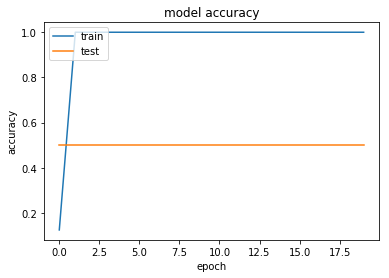

In [189]:
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

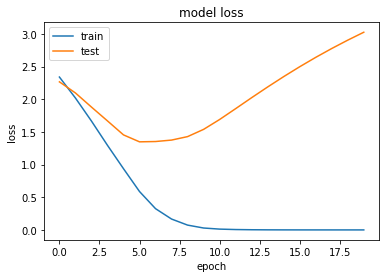

In [190]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5.4.4 循环神经网络(RNN)

#### 5.4.4.1 RNN概述

 1) BP算法,CNN之后, 为什么还有RNN?

细想BP算法,CNN(卷积神经网络)我们会发现, 他们的输出都是只考虑前一个输入的影响而不考虑其它时刻输入的影响, 比如简单的猫,狗,手写数字等单个物体的识别具有较好的效果。

但是, 对于一些与时间先后有关的, 比如视频的下一时刻的预测,文档前后文内容的预测等, 这些算法的表现就不尽如人意了.因此, RNN就应运而生了。

2) 什么是RNN?

RNN是一种特殊的神经网络结构, 它是根据"人的认知是基于过往的经验和记忆"这一观点提出的。

它与DNN,CNN不同的是: 它不仅考虑前一时刻的输入,而且赋予了网络对前面的内容的一种'记忆'功能。

RNN之所以称为循环神经网络，即一个序列当前的输出与前面的输出也有关。

具体的表现形式为网络会对前面的信息进行记忆并应用于当前输出的计算中，即隐藏层之间的节点不再无连接而是有连接的，并且隐藏层的输入不仅包括输入层的输出还包括上一时刻隐藏层的输出。

3) RNN的主要应用领域有哪些呢?

RNN的应用领域有很多, 可以说只要考虑时间先后顺序的问题都可以使用RNN来解决.这里主要说一下几个常见的应用领域:

   ① <font color='red'>自然语言处理(NLP)</font>: 主要有视频处理, 文本生成, 语言模型, 图像处理

   ② 机器翻译, 机器写小说

   ③ 语音识别

   ④ 图像描述生成

   ⑤ 文本相似度计算

   ⑥ 音乐推荐、网易考拉商品推荐、Youtube视频推荐等新的应用领域.

#### 5.4.4.2 RNN详细介绍

##### 5.4.4.2.1 RNN模型结构

前面我们说了RNN具有时间"记忆"的功能, 那么它是怎么实现所谓的"记忆"的呢?

<img src='./image/rnn_1.jpg' />

如图1所示, 我们可以看到RNN层级结构较之于CNN来说比较简单, 它主要有输入层,Hidden Layer, 输出层组成。

注意：图中没有卷积层与池化层。

并且会发现在Hidden Layer 有一个箭头表示数据的循环更新, 这个就是实现时间记忆功能的方法.

如果到这里你还是没有搞懂RNN到底是什么意思,那么请继续往下看!

<img src='./image/rnn_2.png' />

如图所示为Hidden Layer的层级展开图。

t-1, t, t+1表示时间序列 

X表示输入的样本。 

S<sub>t</sub>表示样本在时间t处的的记忆。

S<sub>t</sub> = f(W\*S<sub>t-1</sub> +U\*X<sub>t</sub>)。

W表示输入的权重

U表示此刻输入的样本的权重

V表示输出的样本权重

在t =1时刻, 一般初始化输入S<sub>0</sub>=0, 随机初始化W,U,V, 进行下面的公式计算:

<img src='./image/rnn_f1.png' />

其中,f和g均为激活函数. 其中f可以是tanh,relu,sigmoid等激活函数，g通常是softmax也可以是其他。

 时间就向前推进，此时的状态s<sub>1</sub>作为时刻1的记忆状态将参与下一个时刻的预测活动，也就是:

<img src='./image/rnn_f2.png' />

以此类推, 可以得到最终的输出值为:

<img src='./image/rnn_f3.png' />

注意: 

1. 这里的W,U,V在每个时刻都是相等的(权重共享).

2. 隐藏状态可以理解为:  S=f(现有的输入+过去记忆总结) 

##### 5.4.4.2.2 RNN反向传播

前面我们介绍了RNN的前向传播的方式, 那么RNN的权重参数W,U,V都是怎么更新的呢?

每一次的输出值O<sub>t</sub>都会产生一个误差值E<sub>t</sub>, 则总的误差可以表示为:<img src='./image/rnn_f4.png' />

则<b>损失函数</b>可以使用<b>交叉熵损失函数</b>也可以使用<b>平方误差损失函数</b>.

由于每一步的输出不仅仅依赖当前步的网络，并且还需要前若干步网络的状态，那么这种BP改版的算法叫做<b>Backpropagation Through Time(BPTT)</b> , 也就是将输出端的误差值反向传递,运用梯度下降法进行更新.

>为什么提到梯度就要求偏导数？
毕竟求偏导的物理意义是：表示在某一方向速度随位置变化的快慢（类似加速度）

也就是要求参数的梯度:

<img src='./image/rnn_f5.png' />

首先我们求解W的更新方法, 由前面的W的更新可以看出它是每个时刻的偏差的偏导数之和. 

在这里我们以 t = 3时刻为例, 根据链式求导法则可以得到t = 3时刻的偏导数为:

<img src='./image/rnn_f6.png' />

此时, 根据公式<img src='./image/rnn_f7.png' />， 我们会发现, S3除了和W有关之外, 还和前一时刻S2有关.

对于S3直接展开得到下面的式子:

<img src='./image/rnn_f8.png' />

对于S2直接展开得到下面的式子:

<img src='./image/rnn_f9.png' />

对于S1直接展开得到下面的式子:

<img src='./image/rnn_f10.png' />

 将上述三个式子合并得到:

<img src='./image/rnn_f11.png' />

这样就得到了公式:

<img src='./image/rnn_f12.png' />

这里要说明的是:<img src='./image/rnn_f13.png' />，<br>表示的是S3对W直接求导, 不考虑S2的影响.(也就是例如y = f(x)*g(x)对x求导一样)

其次是对U的更新方法. 由于参数U求解和W求解类似,这里就不在赘述了,最终得到的具体的公式如下:

<img src='./image/rnn_f14.png' />

最后,给出V的更新公式(V只和输出O有关):

<img src='./image/rnn_f15.png' />

#### 5.4.4.3 RNN的一些改进算法

前面我们介绍了RNN的算法, 它处理时间序列的问题的效果很好, 但是仍然存在着一些问题, 其中较为严重的是容易出现梯度消失或者梯度爆炸的问题(BP算法和长时间依赖造成的). 注意: 这里的梯度消失和BP的不一样,这里主要指由于时间过长而造成记忆值较小的现象.

因此, 就出现了一系列的改进的算法, 这里介绍主要的两种算法: LSTM 和 GRU.

LSTM 和 GRU对于梯度消失或者梯度爆炸的问题处理方法主要是:

对于梯度消失: 由于它们都有特殊的方式存储”记忆”，那么以前梯度比较大的”记忆”不会像简单的RNN一样马上被抹除，因此可以一定程度上克服梯度消失问题。

对于梯度爆炸:用来克服梯度爆炸的问题就是gradient clipping，也就是当你计算的梯度超过阈值c或者小于阈值-c的时候，便把此时的梯度设置成c或-c。 

CNN与RNN能否联合起来用呢？有的，这个称之为RCNN:

<img src='./image/cnnrnn.jpg' />

<img src='./image/netrocompare.png' />

# 6. 样本准备